In [1]:
%matplotlib notebook
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 
# from pyntcloud import PyntCloud
# import pptk

In [2]:
# # these can be pre-computed, just need to re-apply the road mask each frame
# y_cam = 1.77; fov_h = 1.0
# width = 2048; height = 1024
# # (width, height) = img.shape

# us = np.arange(width) - width/2 + 0.5
# vs_inv = 1/(np.arange(height/2-1)+1)   # ignore the horizon line (v = 0)
# uu, vv_inv = np.meshgrid(us, vs_inv)
# x = uu * vv_inv * y_cam
# y = np.ones(uu.shape) * y_cam
# z = 0.5 * width * vv_inv / np.tan(0.5 * fov_h) * y_cam

def computeDepthMap(y_root=1.77, fov_h=1.0, w=2048, h=1024, normal=np.array([0.0,1.0,0.0])):
    us = np.arange(w) - w/2 + 0.5
    vs = np.arange(h/2-1)+1   # ignore the horizon line (v = 0)
    uu, vv = np.meshgrid(us, vs)
    alpha = 0.5 * w / np.tan(0.5 * fov_h)
    frac = y_root * normal[1] / (normal[0]*uu + normal[1]*vv + normal[2]*alpha)
    x = -uu * frac
    y = -vv * frac + y_root
    z = alpha * frac
    
    PROB_GAIN = 1500
    invProbMap = 1.0 / z * np.random.random_sample(uu.shape) * PROB_GAIN
    return (x, y, z), invProbMap

# import timeit
# timeit.timeit('computeDepthMap(w=1024,h=512,normal=np.array([1.0/3,2.0/3,2.0/3]))', globals=globals(),number=20) / 20

In [14]:
labelIds = {'ROAD':7, 'BUILDING':11, 'TRAF_LIGHT':19, 'TRAF_SIGN':20, 'PLANT':21, 'TERRAIN':22, 'SKY':23, 'CAR':26}
MAX_RANGE = 100.0

def castTo3D(img):
    xs = []
    ys = []   # can discard the y values later
    zs = []
    labels = []
    
    (height, width) = img.shape
    (x,y,z),p = computeDepthMap(w = width, h = height)   # probability, p, not used so far
    
    for label, idx in labelIds.items():
        mask = ((img[(height//2+1):, :] == idx) & ((p < 1.0)))   # mask and down-sample
        numEntries = sum(sum(mask))
#         print(label,': ', numEntries)
        if numEntries > 0:
            xs.extend(x[mask].ravel())
            ys.extend(y[mask].ravel())
            zs.extend(z[mask].ravel())
            labels.extend([label] * numEntries)

#     df = pd.DataFrame({'x': -x[mask].ravel(), 'y': -y[mask].ravel(), 'z': z[mask].ravel()})
    df = pd.DataFrame({'x': xs, 'y': ys, 'z': zs, 'label':labels})
    df = df.drop(df[df.z > MAX_RANGE].index)
    return df

<IPython.core.display.Javascript object>


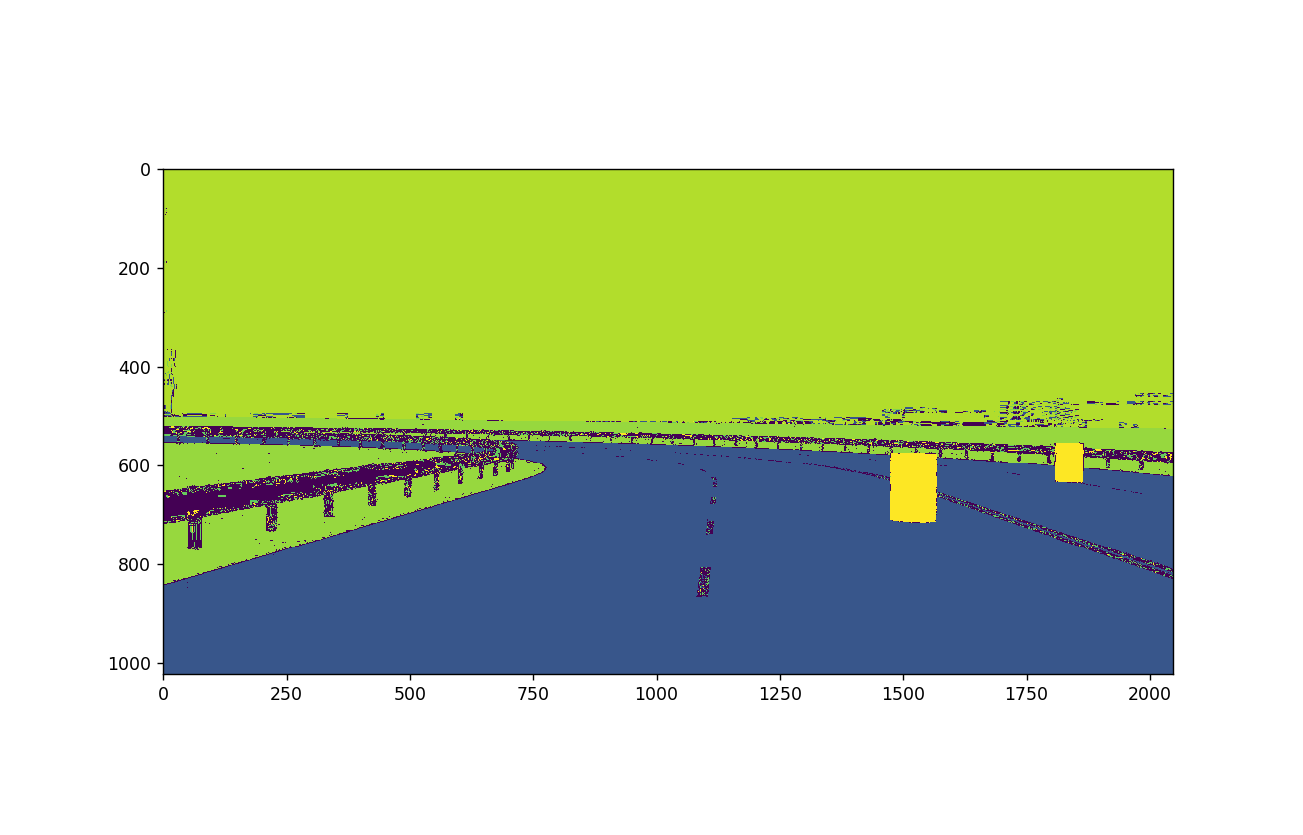

In [4]:
# img = np.ones((height, width), dtype=np.uint8)   # height = # rows, width = # cols

img = cv2.imread('dataset/gtFine/train/abc/0320_gtFine_labelIds.png',0)

plt.figure(2); plt.imshow(img); plt.show()
# plt.savefig('mapdemo_seg.png', bbox_inches='tight')

In [ ]:
# for export to matlab

# df_MATLAB = castTo3D(img)
# df_MATLAB['IsRoad'] = (df_MATLAB.label == 'ROAD').astype(int)
# df_MATLAB.drop('label', axis=1, inplace=True)
# df_MATLAB.to_csv('castTo3D_pts.csv', index=False)

import timeit
timeit.timeit('castTo3D(img)', globals=globals(),number=5) / 5

In [13]:
# extract road points only for visualization
# import pptk

# df = castTo3D(img)
# df = df[df.label == 'ROAD']
# df.drop('label', axis=1, inplace=True)

# xyz = df.to_numpy()
# v = pptk.viewer(xyz, point_size=10.0)


# fig = plt.figure(2)
# ax = fig.add_subplot(111, projection='3d')
# X = xyz.x; Y = xyz.y; Z = xyz.z
# ax.scatter(X, Y, Z)

# ax.set_xlabel('X Label')
# ax.set_ylabel('Y Label')
# ax.set_zlabel('Z Label')

# max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0

# mid_x = (X.max()+X.min()) * 0.5
# mid_y = (Y.max()+Y.min()) * 0.5
# mid_z = (Z.max()+Z.min()) * 0.5
# ax.set_xlim(mid_x - max_range, mid_x + max_range)
# ax.set_ylim(mid_y - max_range, mid_y + max_range)
# ax.set_zlim(mid_z - max_range, mid_z + max_range)

# plt.show()

In [5]:
ROAD = 1
NO_IMG = -1
OBSTACLE = 0

def make_grid(positions, d=1.0):
    # grid is nu by nv and is centered at u = nu/2, v = 0
    pos_max = np.max(positions, axis=0)
    pos_min = np.min(positions, axis=0)
    nu = int((pos_max[0] - pos_min[0]) // d) + 1
    nv = int((pos_max[2] - pos_min[2]) // d) + 1
    grid = -np.ones((nu, nv), dtype=np.int8)    # fill with NO_IMG
    
    for pos in positions:
        u = int((pos[0] - pos_min[0]) // d)
        v = int((pos[2] - pos_min[2]) // d)
#         if point.label == 'ROAD':
        if pos[3] == 'CAR':
            grid[u,v] = OBSTACLE
        elif grid[u,v] == ROAD:
            continue
        elif (pos[3] == 'ROAD'):# or (pos[3] == 'TRAF_SIGN'):
            grid[u,v] = ROAD    # can accumulate totals, but need to use a different 'invalid' flag (currently -1)
        else:
            grid[u,v] = OBSTACLE    # 1 for road cells, 0 for non-road cells
            
    # perform flood-fill and get the main road's mask
    # TODO: can try flood-filling no-img CCs that are surrounded by main road CC
    # idea: 1 round of averaging
    mask = np.array(grid, copy=True)
    mask[mask < 0] = 0
    mask = mask.astype('uint8')
    MASK_VALUE = 15
    
    TRIAL_DIST = 3
    for i in range(-TRIAL_DIST, TRIAL_DIST):
        for j in range(TRIAL_DIST):
            if mask[nu // 2 + i,j] == 0 or mask[nu // 2 + i,j] == MASK_VALUE:
                continue
            else:
#                 print("filling!")
                cv2.floodFill(mask, None, (j, nu // 2 + i), MASK_VALUE)
    mask = (mask == MASK_VALUE)
    grid[grid == ROAD] = mask[grid == ROAD]
    return grid

def draw_grid(grid):
    nu, nv = grid.shape
    us = np.arange(nu); vs = np.arange(nv)
    uu,vv = np.meshgrid(vs,us)
    c = plt.pcolormesh(uu, vv, grid, cmap ='Greens', vmin = np.min(grid), vmax = np.max(grid)) 
    plt.colorbar(c) 
    plt.title('Discrete map', fontweight ="bold") 
    plt.show() 

x = make_grid(castTo3D(img).to_numpy(), d=1.5)

<IPython.core.display.Javascript object>


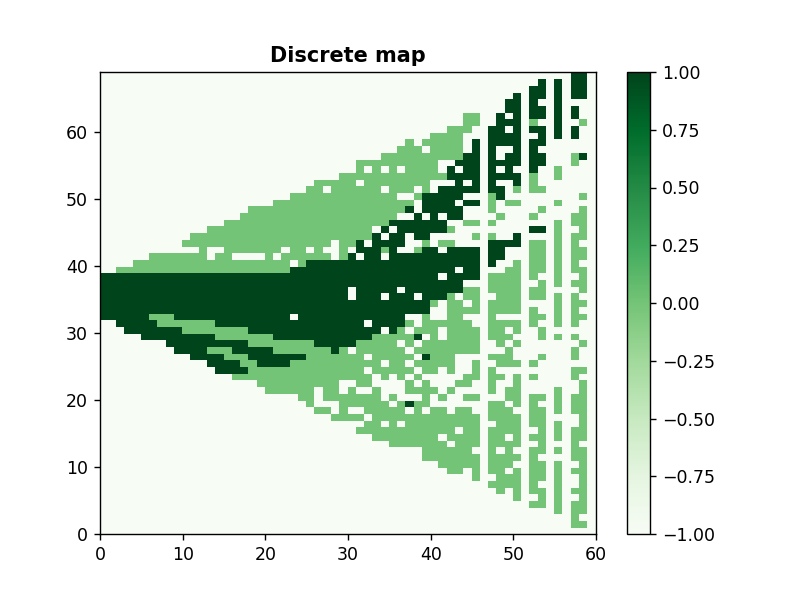

<IPython.core.display.Javascript object>


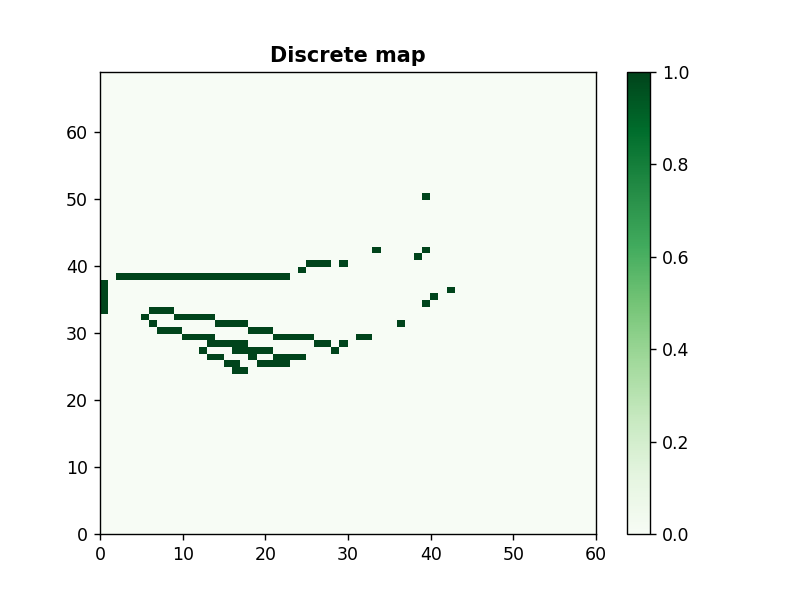

In [7]:
def computeWalls(grid):
    # TODO: walls near no-img gaps are not added
    walls = np.zeros(grid.shape,dtype=np.uint8)
    
    count_nb_roads = np.zeros(grid.shape, dtype=np.uint8)
    count_nb_roads[:-1,:] += (grid[1:,:] == ROAD)
    count_nb_roads[1:,:] += (grid[:-1,:] == ROAD)
    count_nb_roads[:,:-1] += (grid[:,1:] == ROAD)
    count_nb_roads[:,1:] += (grid[:,:-1] == ROAD)
    # if road cell has < 4 adj road cells, it's on the perimeter. put up a wall.
    walls[(grid == ROAD) & (count_nb_roads < 4)] = 1

    # this is more aggressive: squares that are half-road, half-ground are labeled as road.
    # only tiles that are 100% ground are labeled as walls and avoided.
#     walls[(grid == OBSTACLE) & (count_nb_roads > 0)] = 1

    count_noimg = np.zeros(grid.shape, dtype=np.uint8)
    count_noimg[:-1,:] += (grid[1:,:] == NO_IMG)
    count_noimg[1:,:] += (grid[:-1,:] == NO_IMG)
    count_noimg[:,:-1] += (grid[:,1:] == NO_IMG)
    count_noimg[:,1:] += (grid[:,:-1] == NO_IMG)
    count_noimg[-1,:] += 1
    count_noimg[:,-1] += 1
    
    # if the road cell is at the image border, there may not actually be an obstacle there.
    # so don't put a wall.
    walls[(grid == ROAD) & (count_noimg > 0)] = 0
    return walls

# plt.figure(30)
# draw_grid(computeWalls(x))

def computeGoal(grid):
    nu, nv = grid.shape
    us = np.arange(nu) - nu // 2
    vs = np.arange(nv)
    uu, vv = np.meshgrid(vs,us)
    dists = np.zeros(grid.shape, dtype=np.uint16)
    tmp = uu**2 + vv**2
    dists[grid == ROAD] = tmp[grid == ROAD]
#     plt.figure(3)
#     draw_grid(dists)
    return np.unravel_index(dists.argmax(), dists.shape)

walls = computeWalls(x)
goal = computeGoal(x)
# x[goal] = 3
# print(x[goal])
plt.figure(3)
draw_grid(x)
# plt.savefig('mapdemo_map_noCC.png', bbox_inches='tight')
plt.figure(4)
draw_grid(walls)
# plt.savefig('mapdemo_walls.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


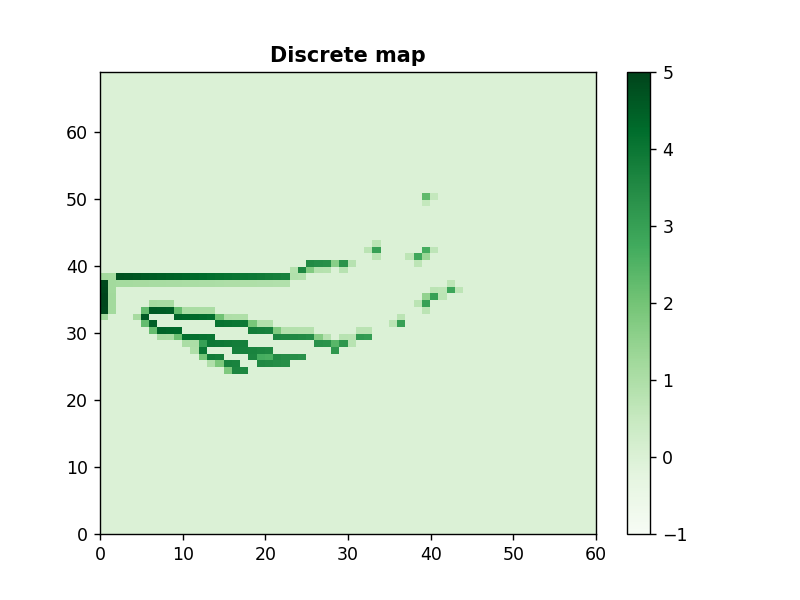

<IPython.core.display.Javascript object>


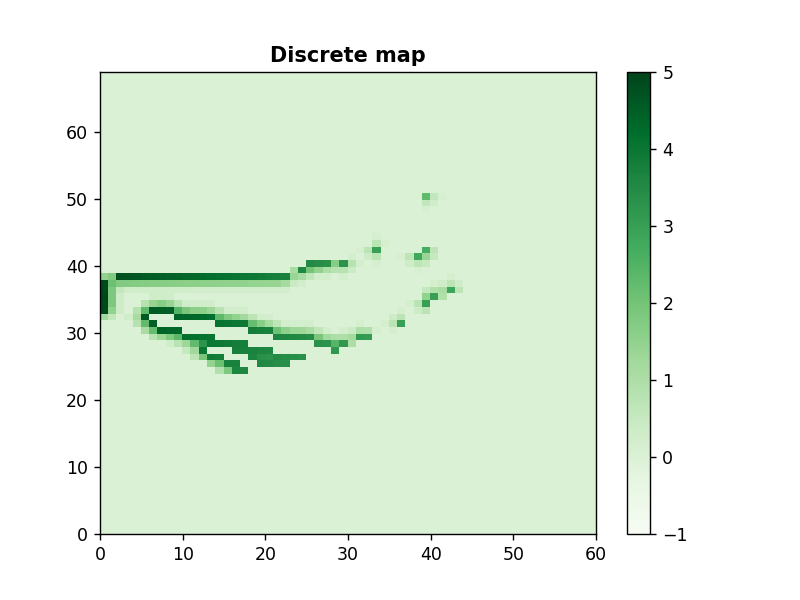

<IPython.core.display.Javascript object>


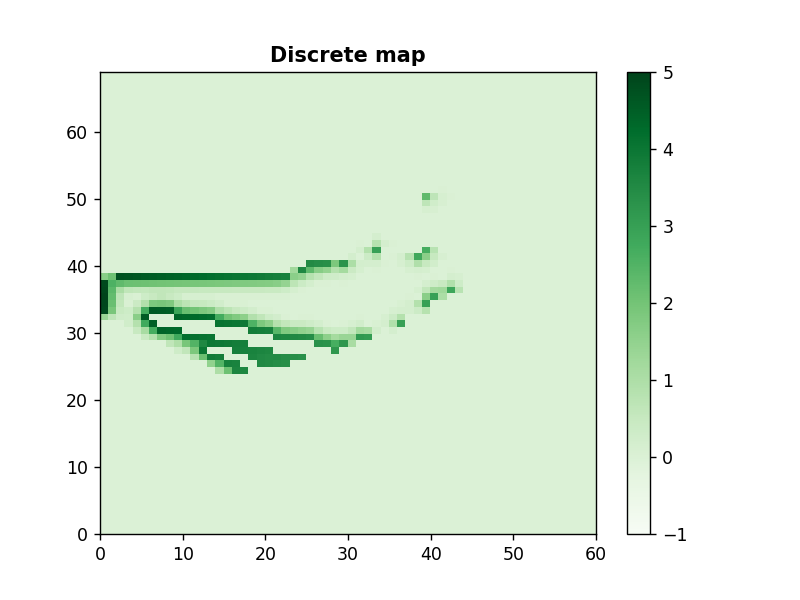

<IPython.core.display.Javascript object>


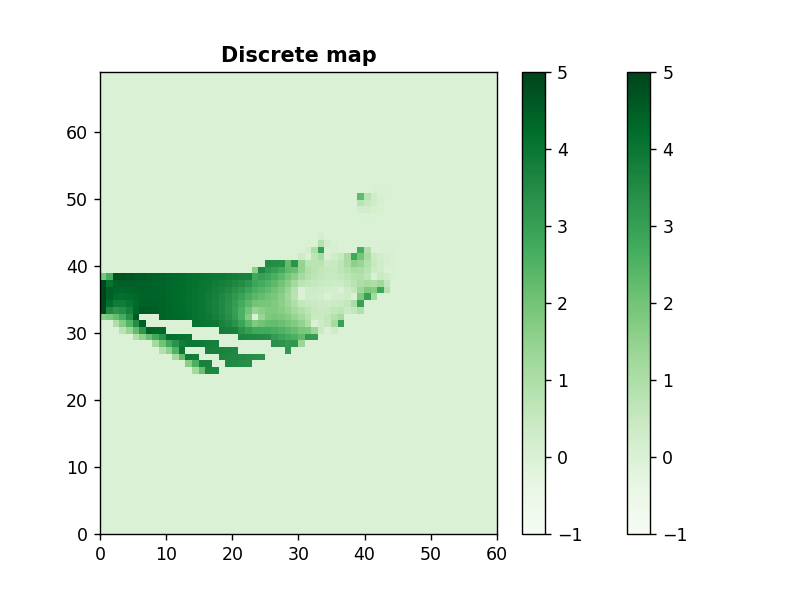

<IPython.core.display.Javascript object>


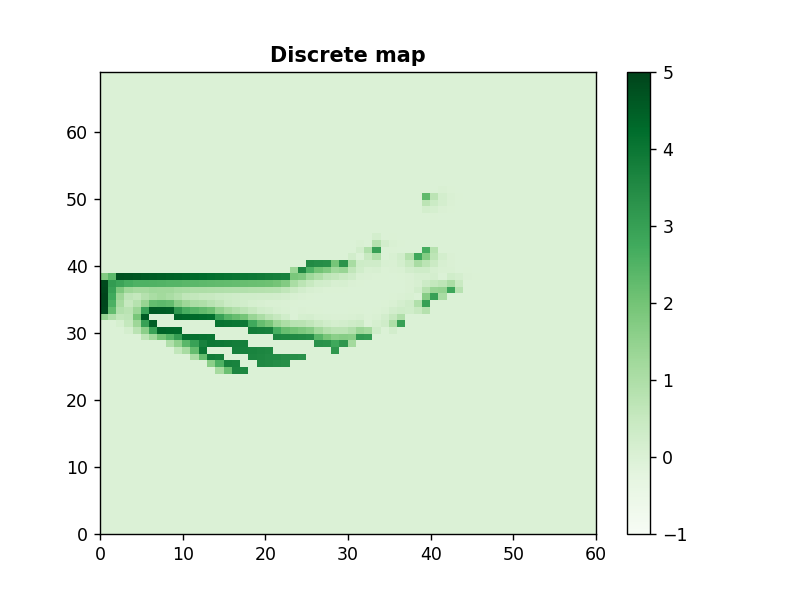

<IPython.core.display.Javascript object>


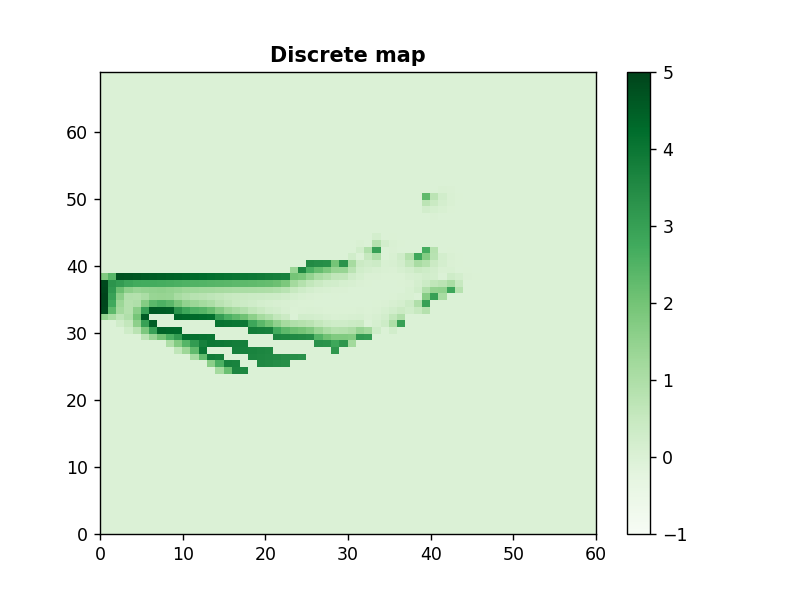

<IPython.core.display.Javascript object>


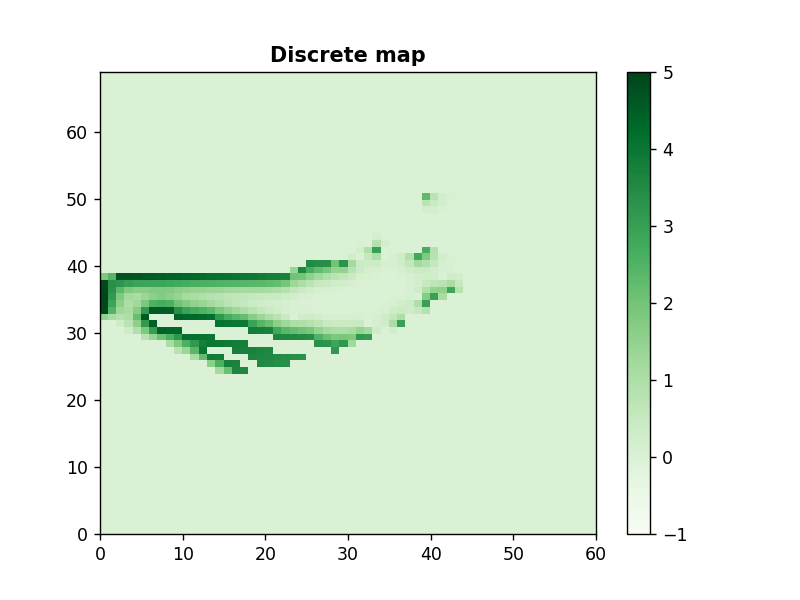

<IPython.core.display.Javascript object>


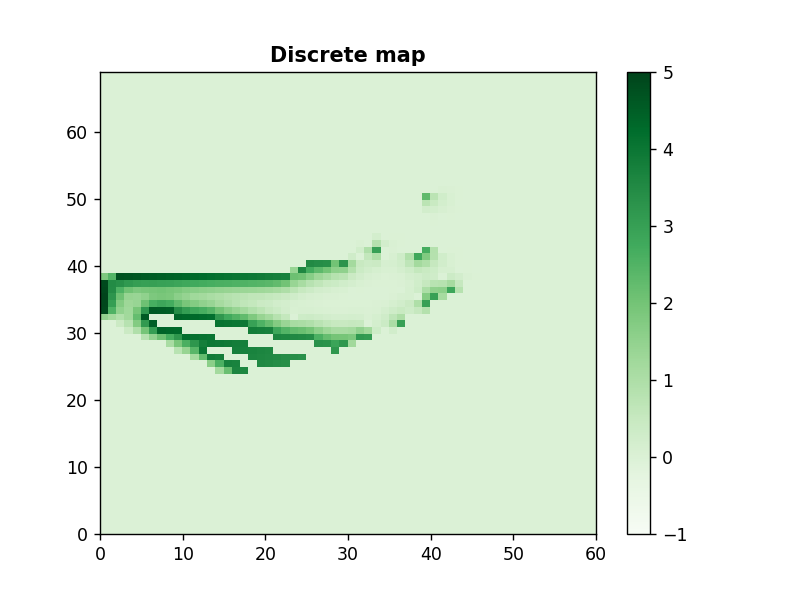

<IPython.core.display.Javascript object>


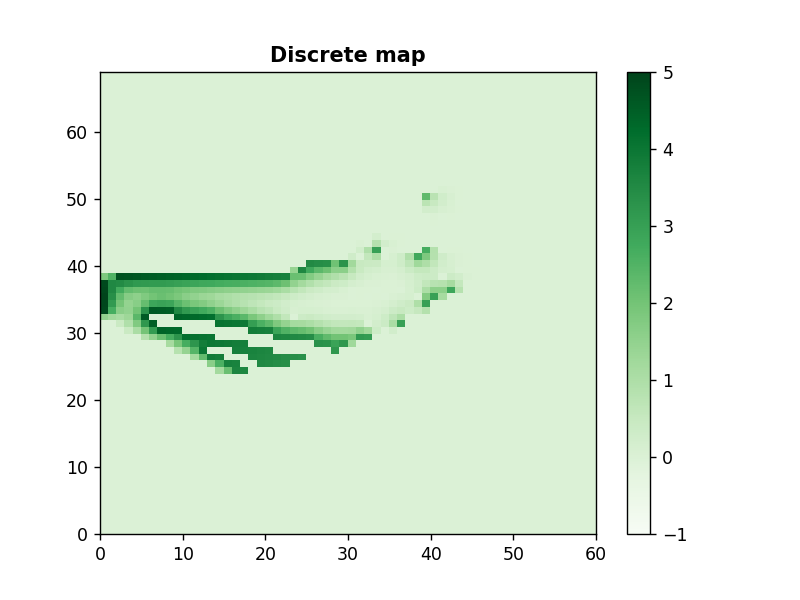

<IPython.core.display.Javascript object>


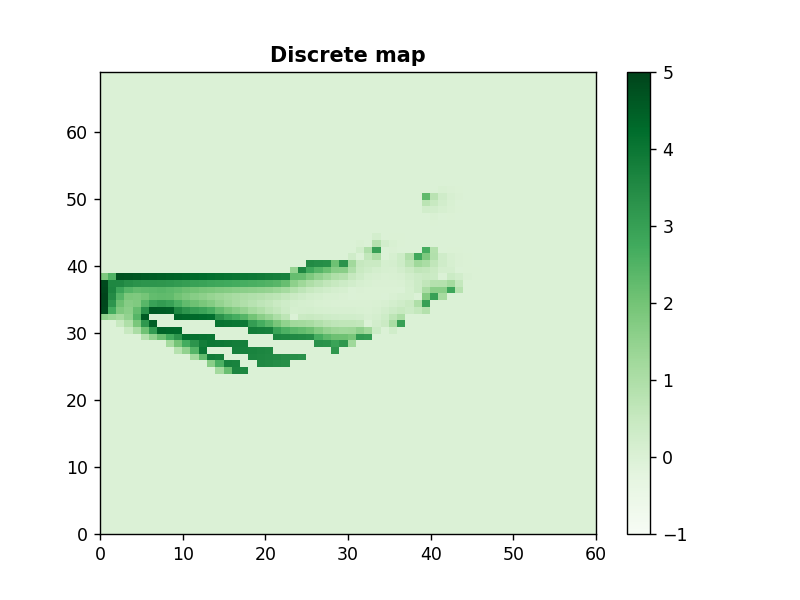

<IPython.core.display.Javascript object>


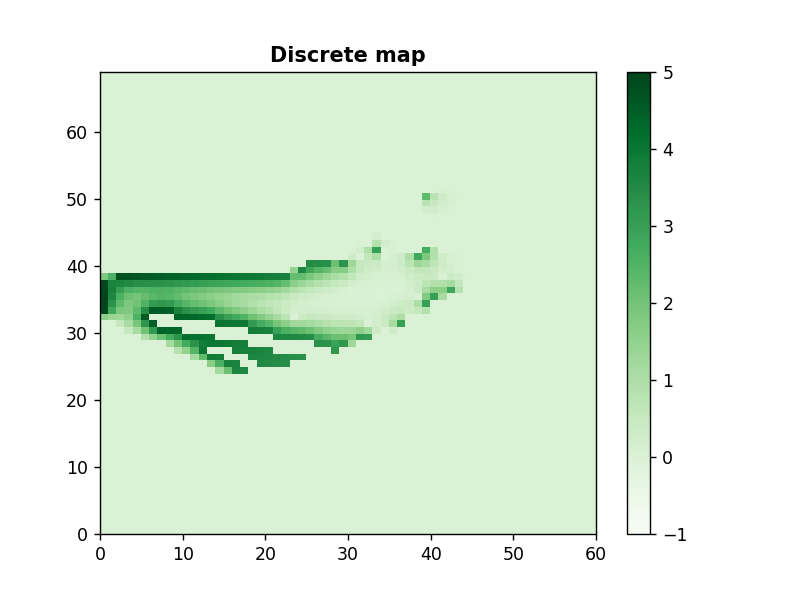

<IPython.core.display.Javascript object>


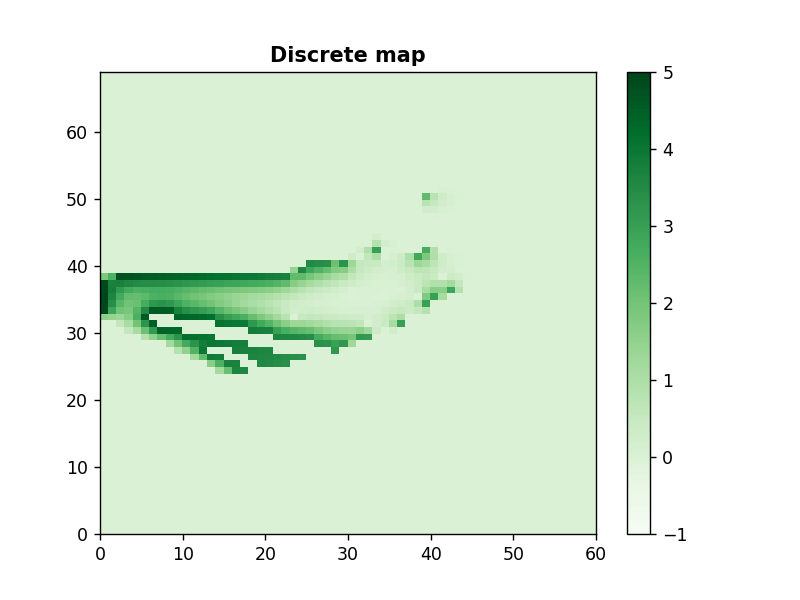

<IPython.core.display.Javascript object>


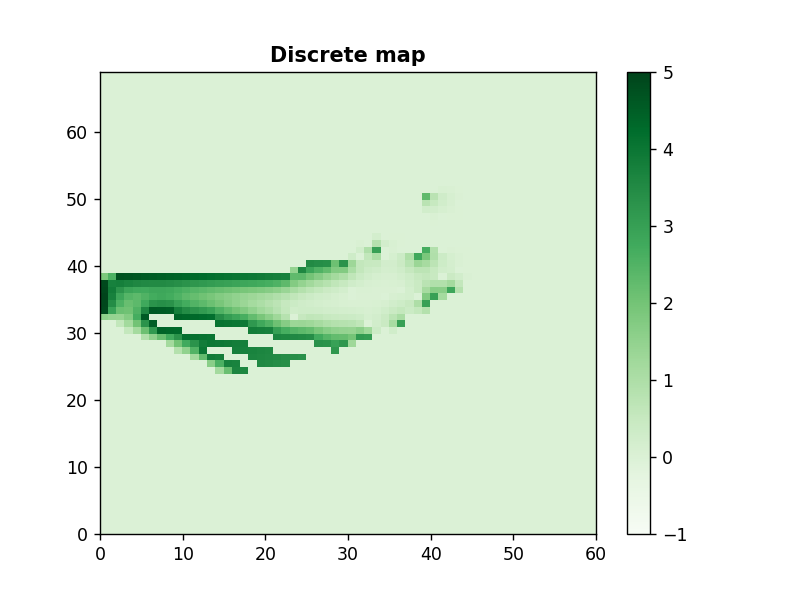

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


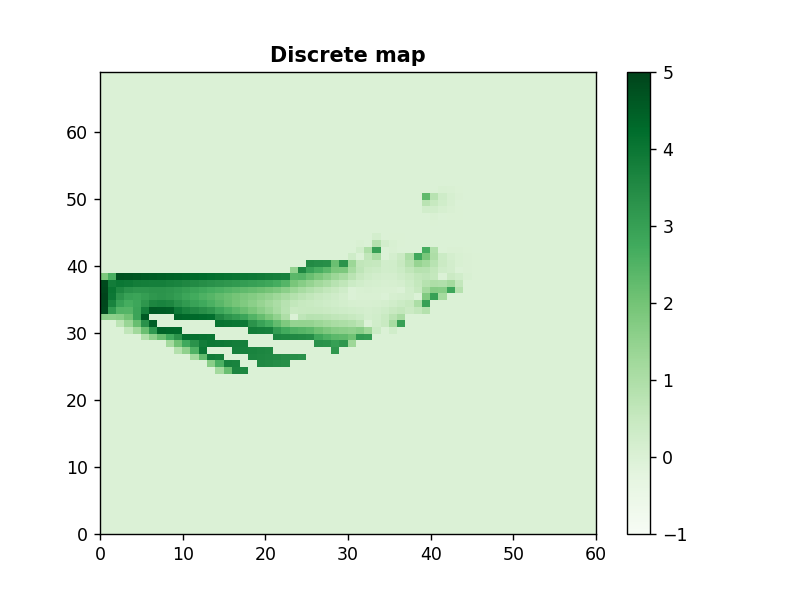

c:\users\charcoal\appdata\local\programs\python\python37\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


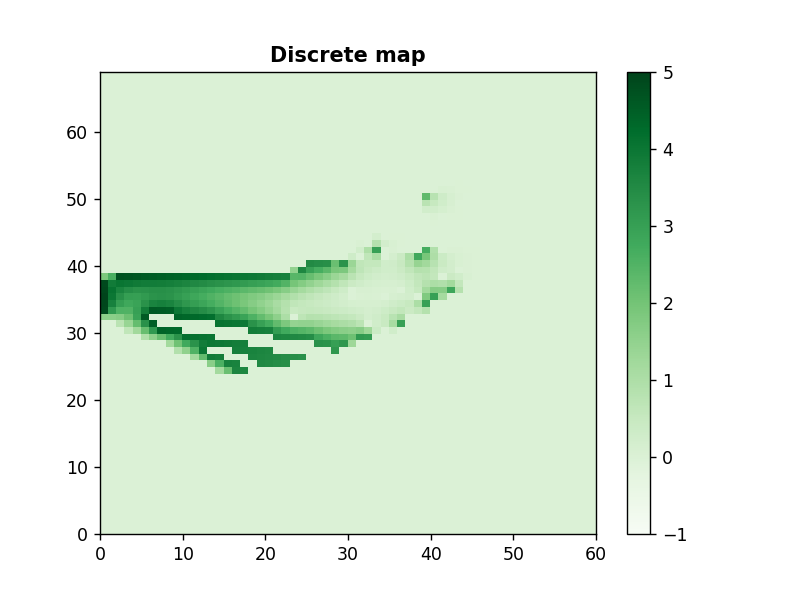

<IPython.core.display.Javascript object>


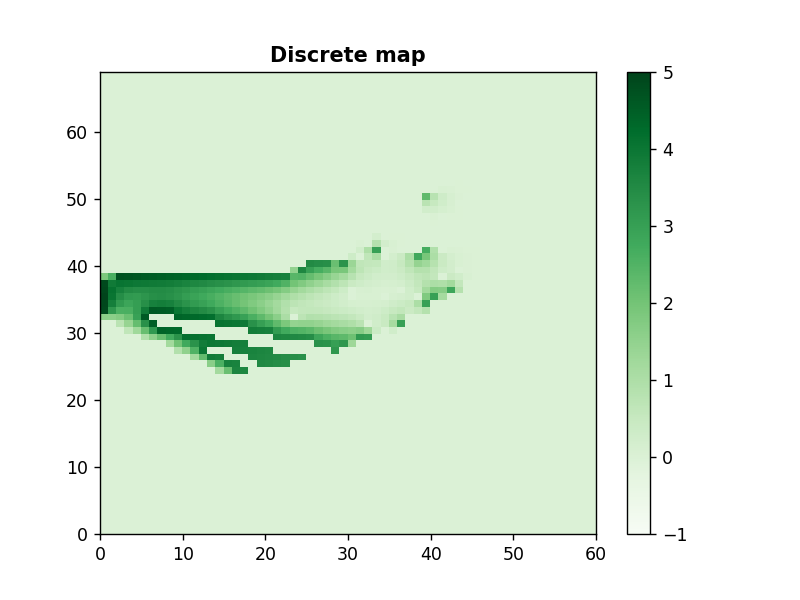

<IPython.core.display.Javascript object>


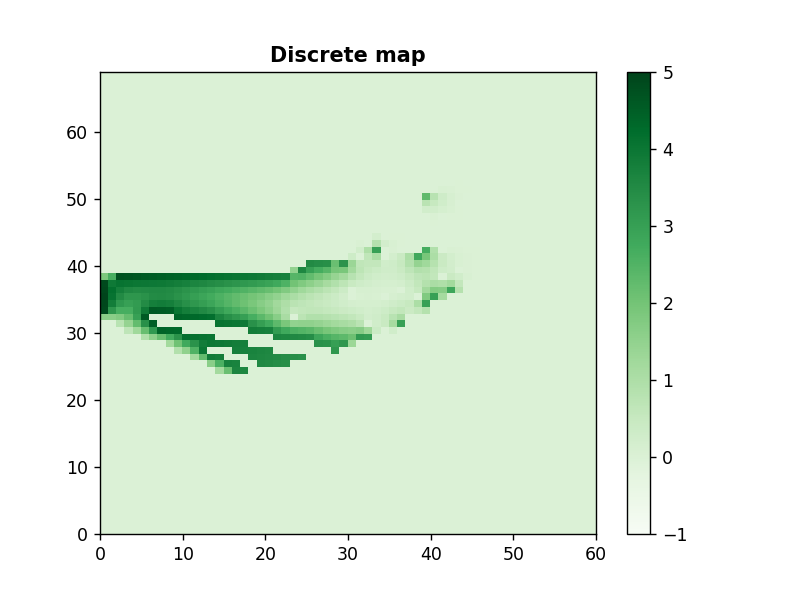

<IPython.core.display.Javascript object>


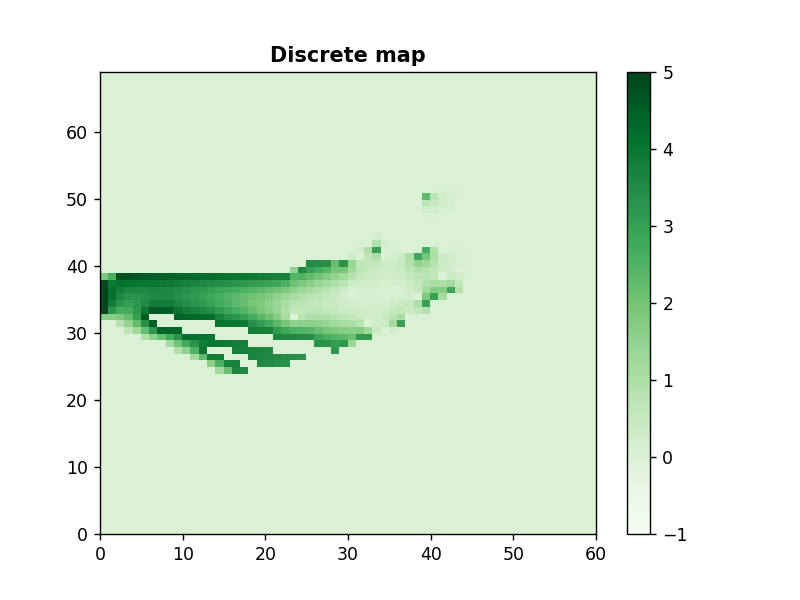

<IPython.core.display.Javascript object>


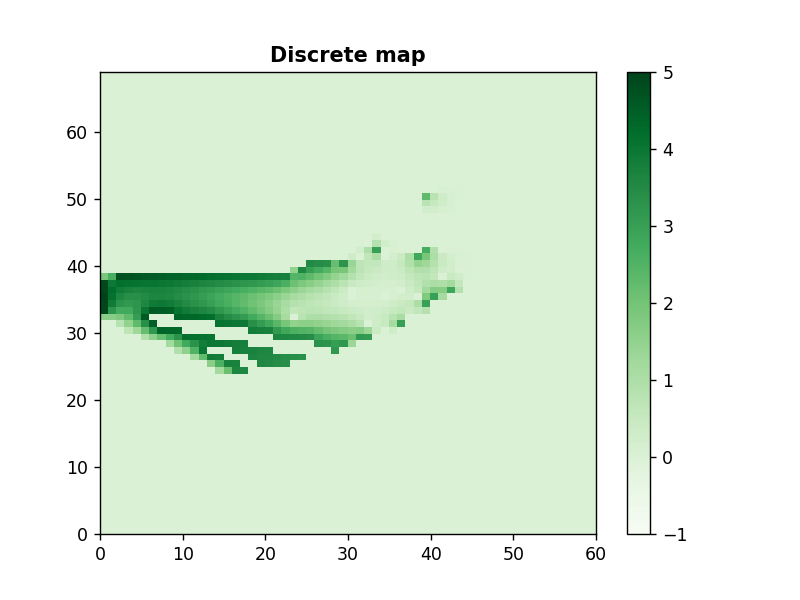

<IPython.core.display.Javascript object>


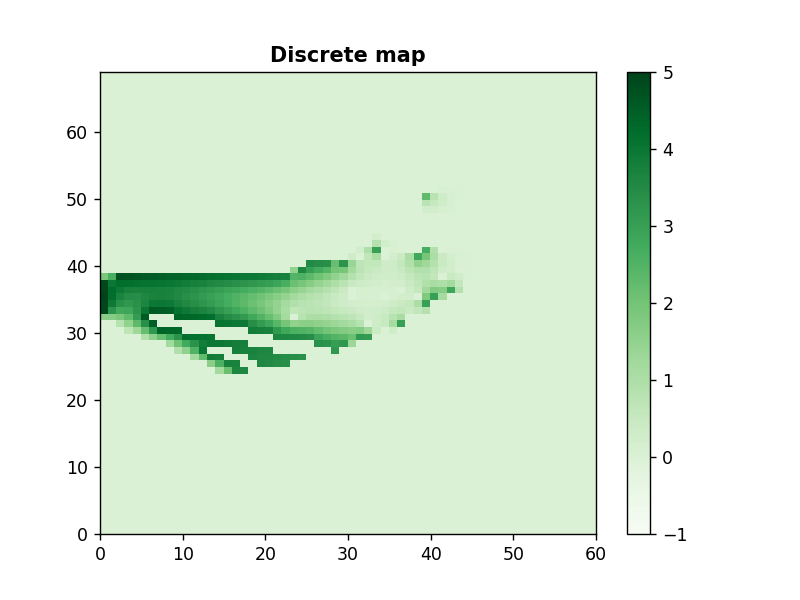

<IPython.core.display.Javascript object>


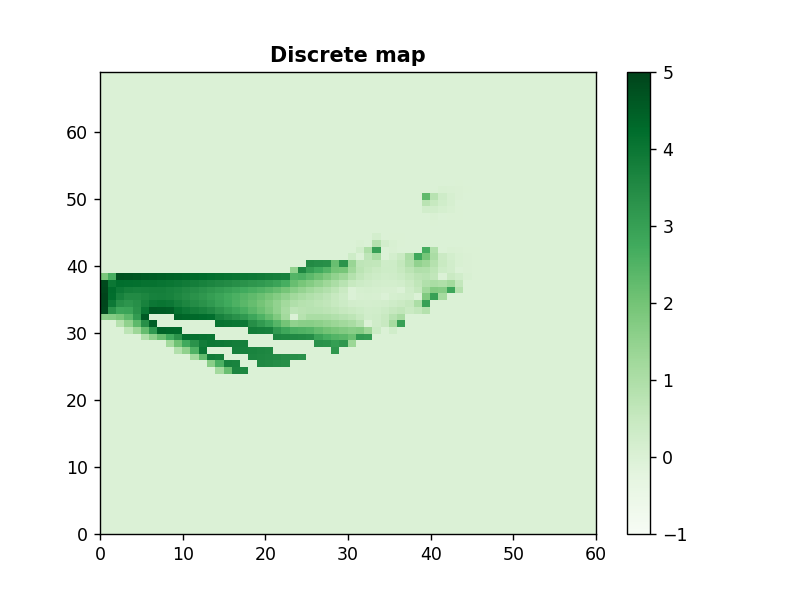

<IPython.core.display.Javascript object>


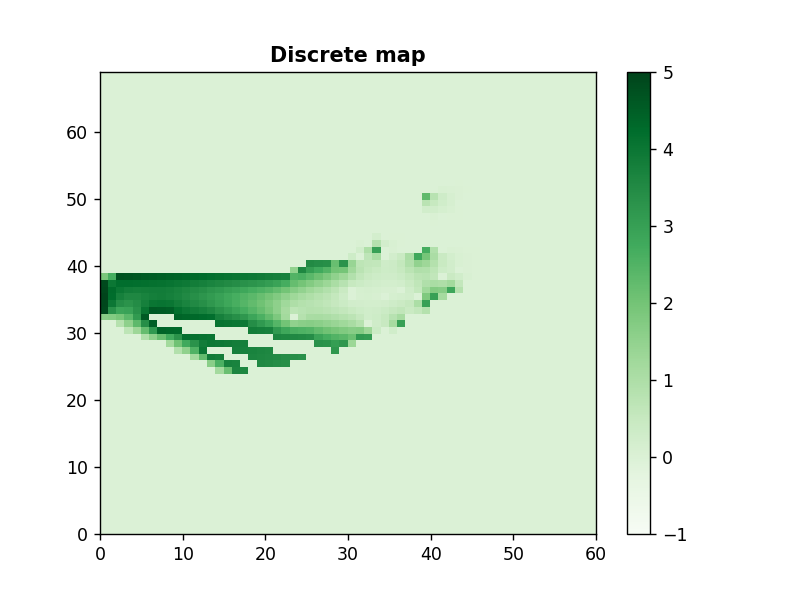

<IPython.core.display.Javascript object>


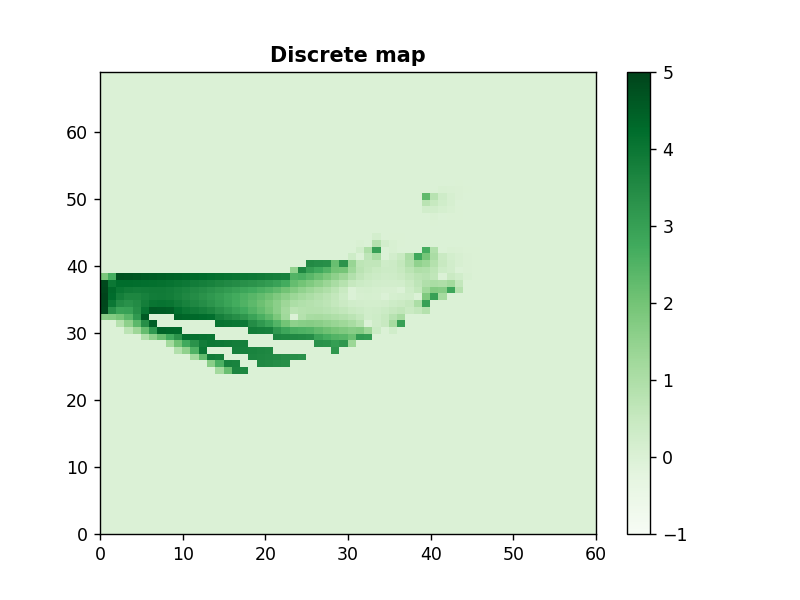

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


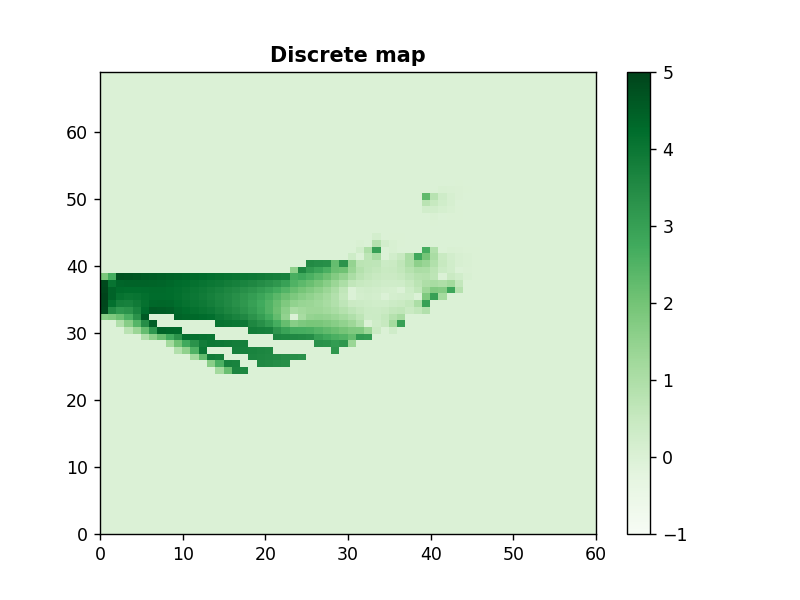

<IPython.core.display.Javascript object>


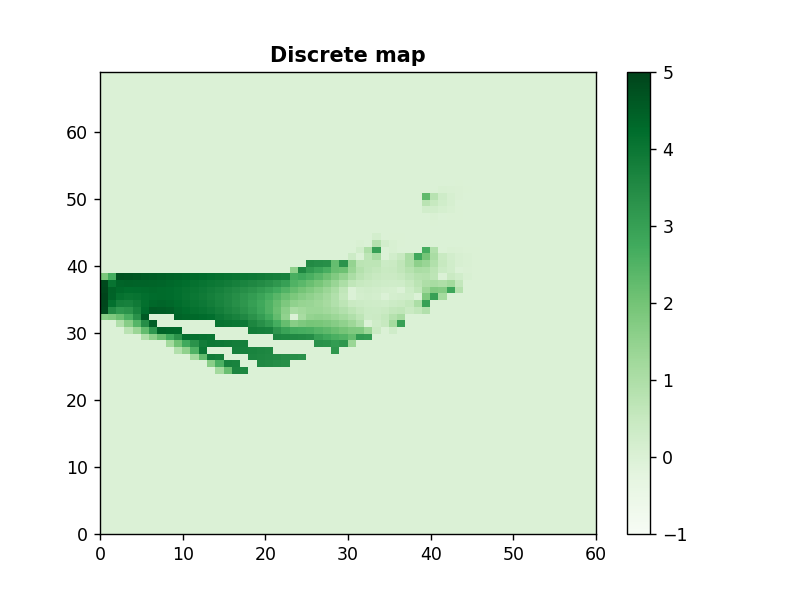

<IPython.core.display.Javascript object>


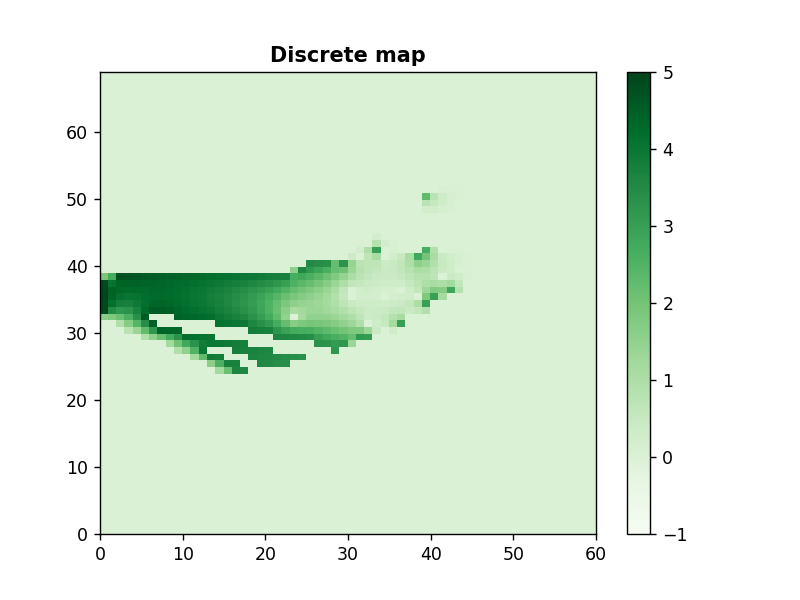

<IPython.core.display.Javascript object>


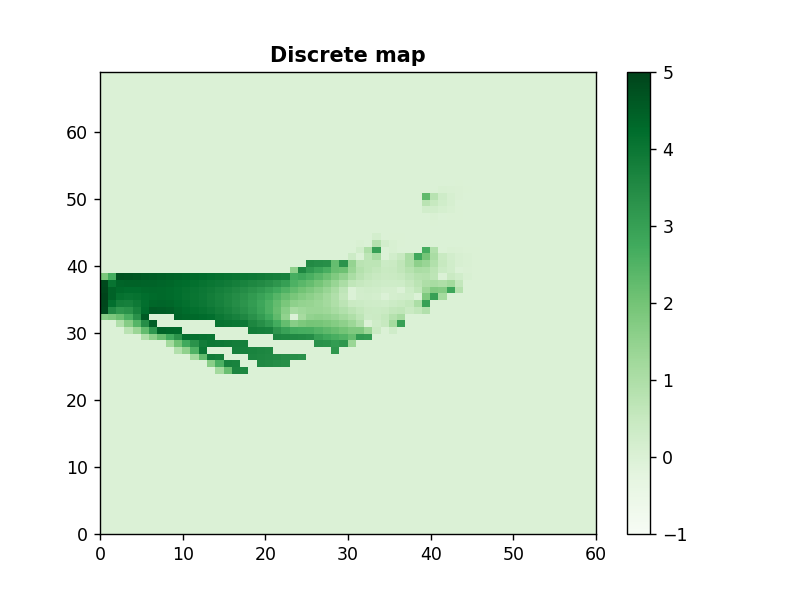

<IPython.core.display.Javascript object>


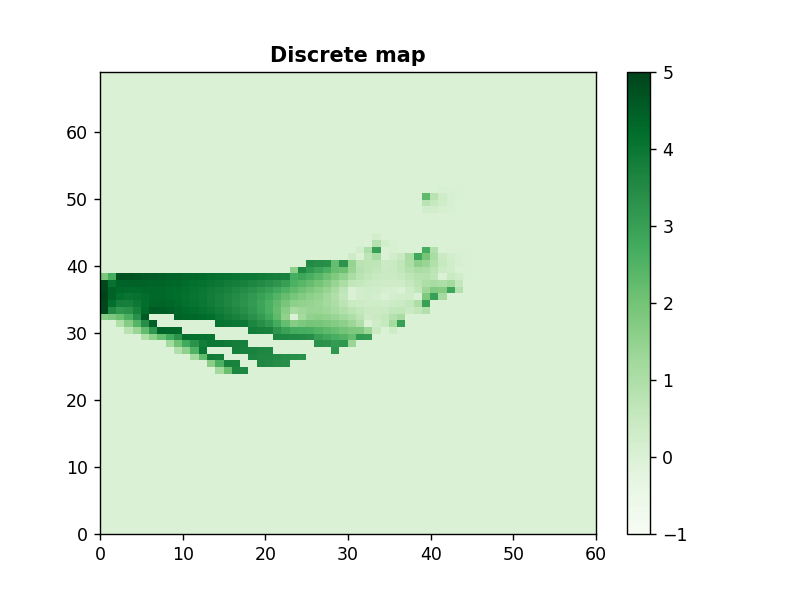

<IPython.core.display.Javascript object>


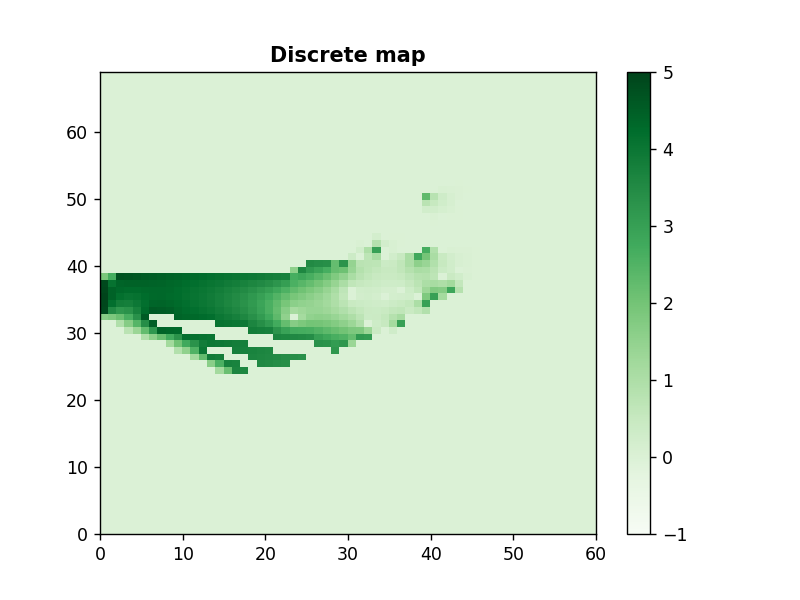

<IPython.core.display.Javascript object>


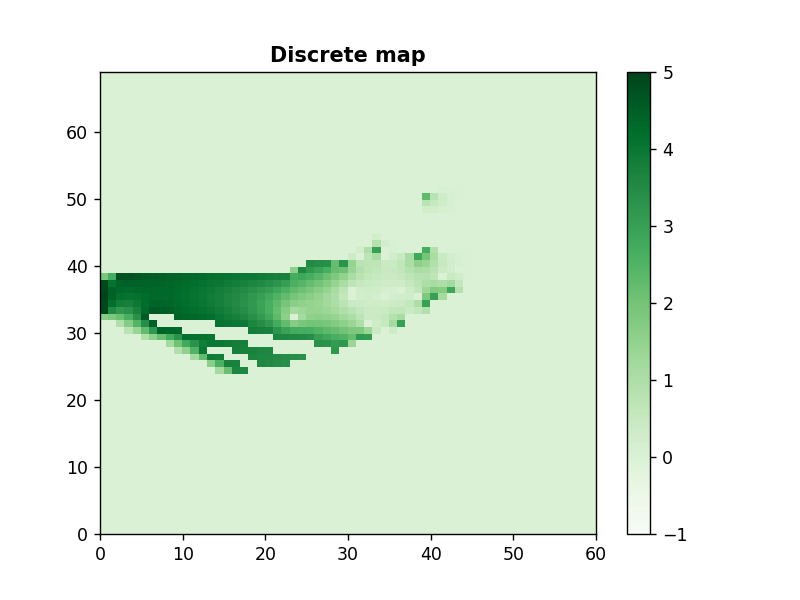

<IPython.core.display.Javascript object>


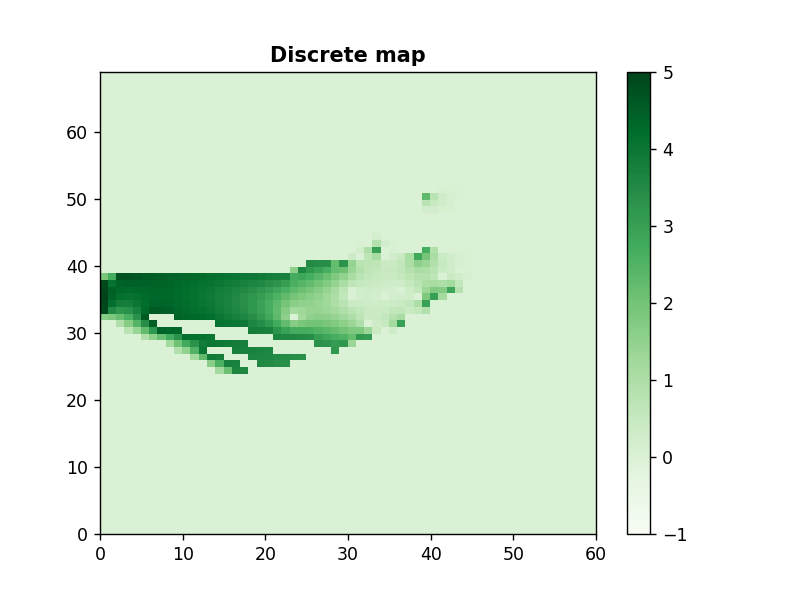

<IPython.core.display.Javascript object>


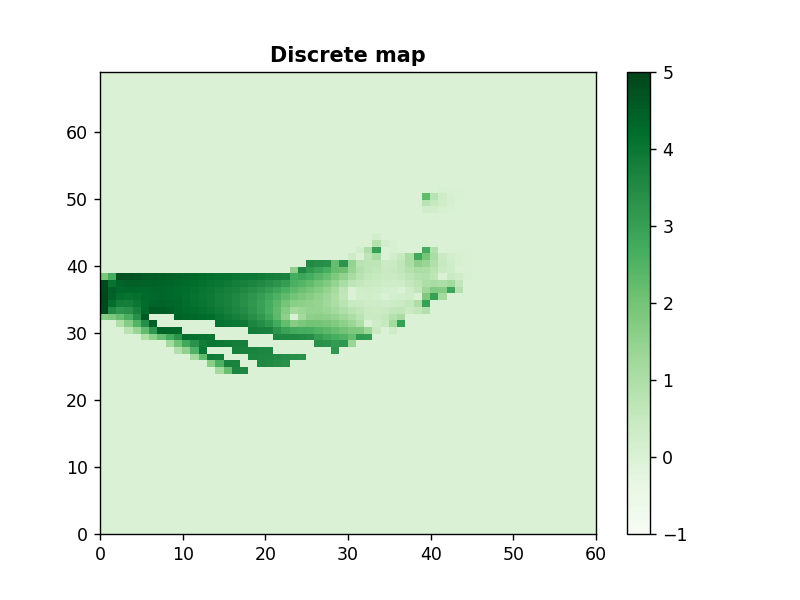

<IPython.core.display.Javascript object>


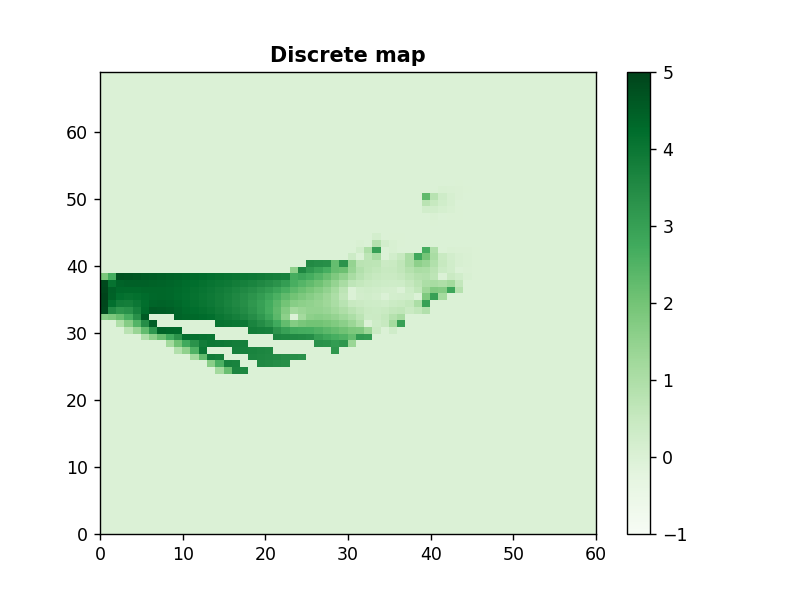

<IPython.core.display.Javascript object>


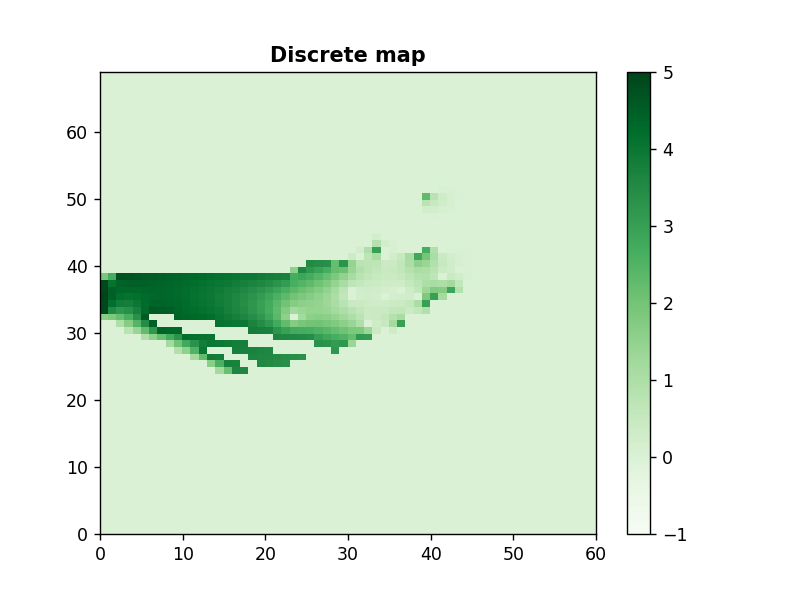

<IPython.core.display.Javascript object>


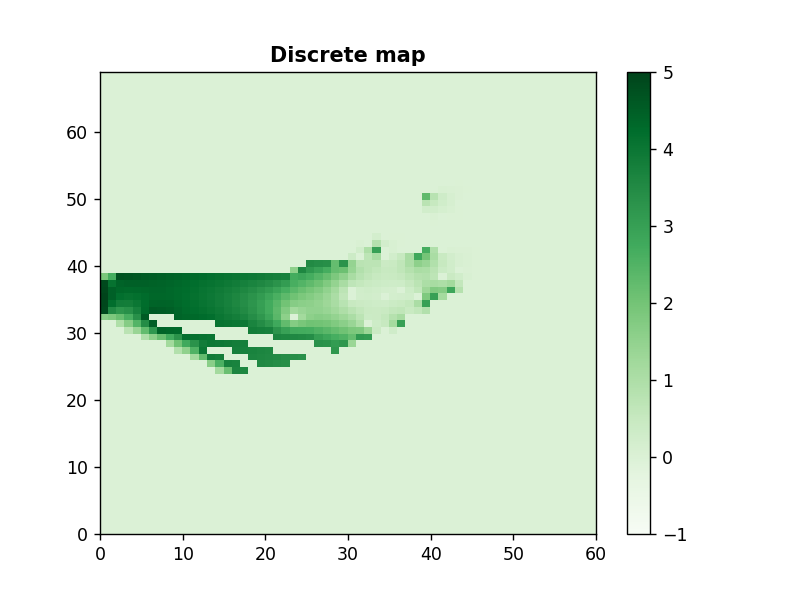

<IPython.core.display.Javascript object>


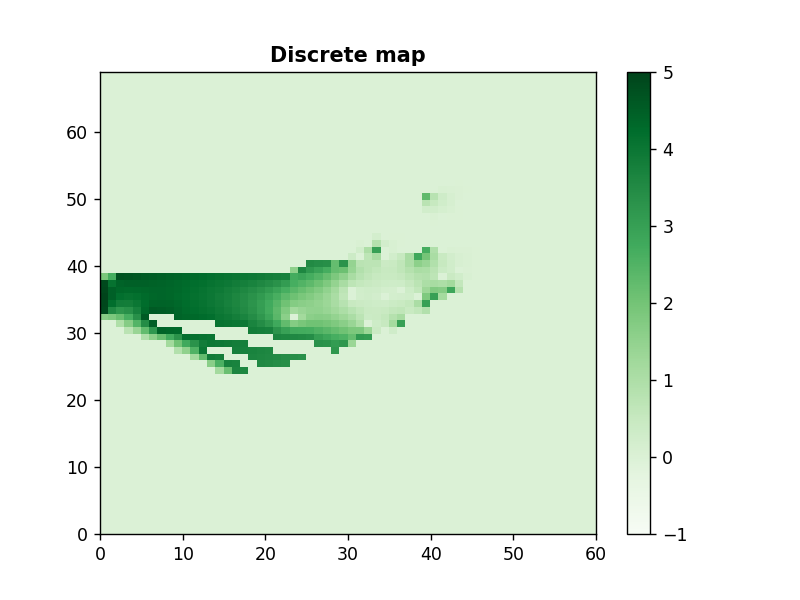

<IPython.core.display.Javascript object>


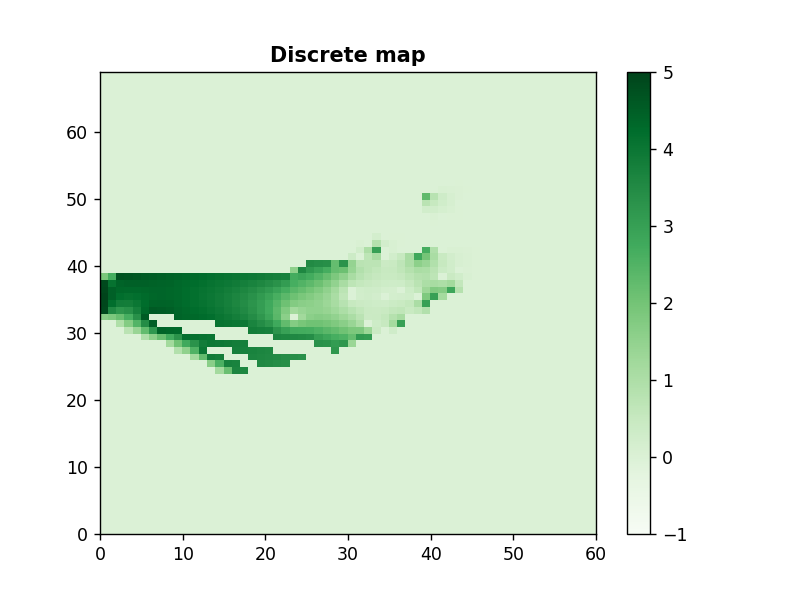

<IPython.core.display.Javascript object>


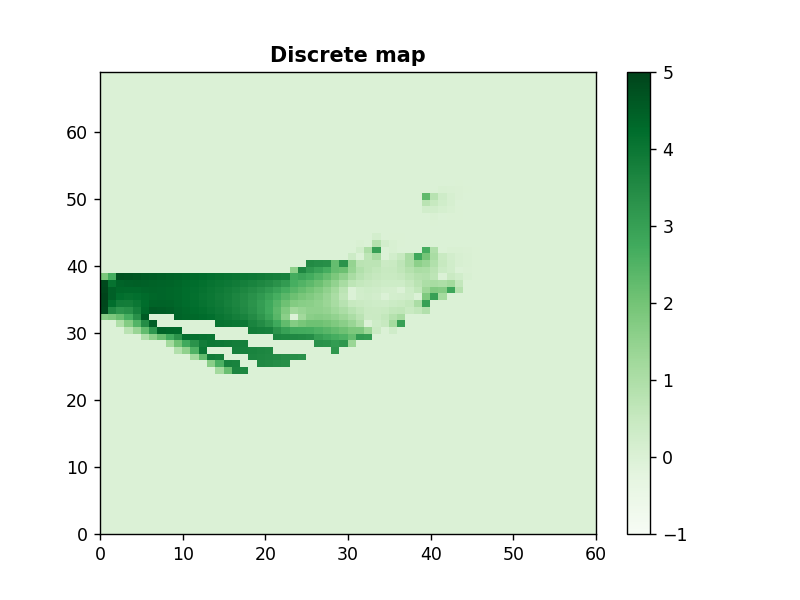

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


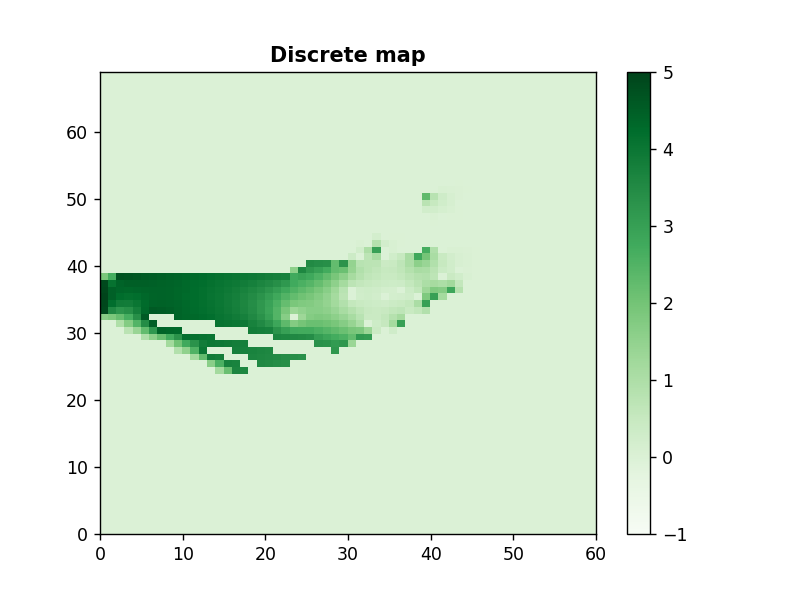

<IPython.core.display.Javascript object>


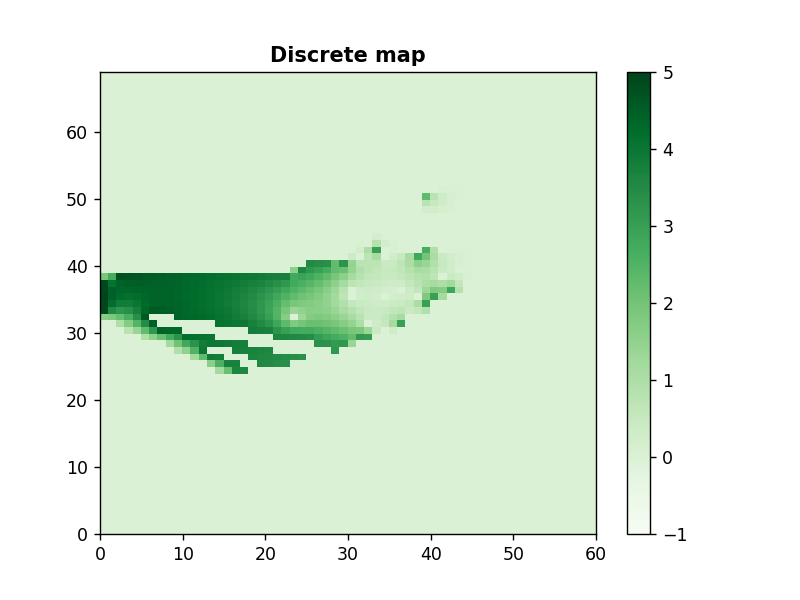

<IPython.core.display.Javascript object>


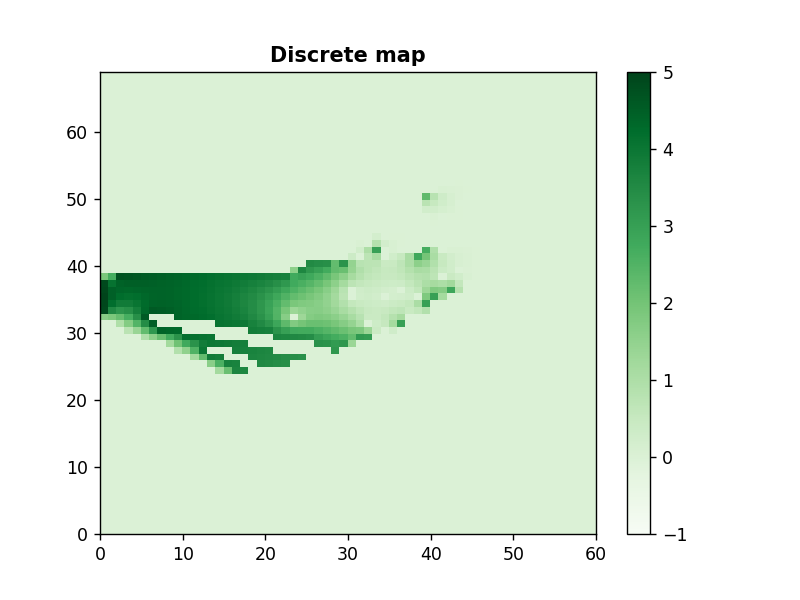

<IPython.core.display.Javascript object>


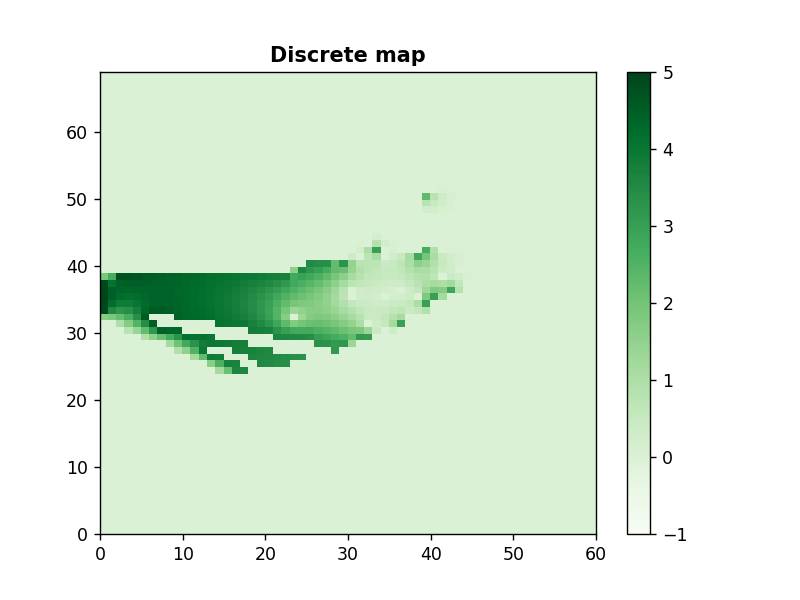

<IPython.core.display.Javascript object>


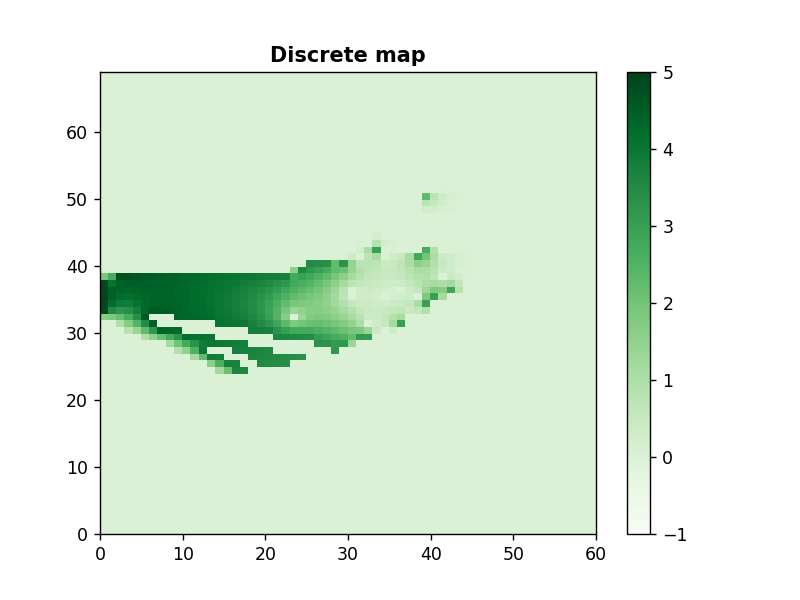

<IPython.core.display.Javascript object>


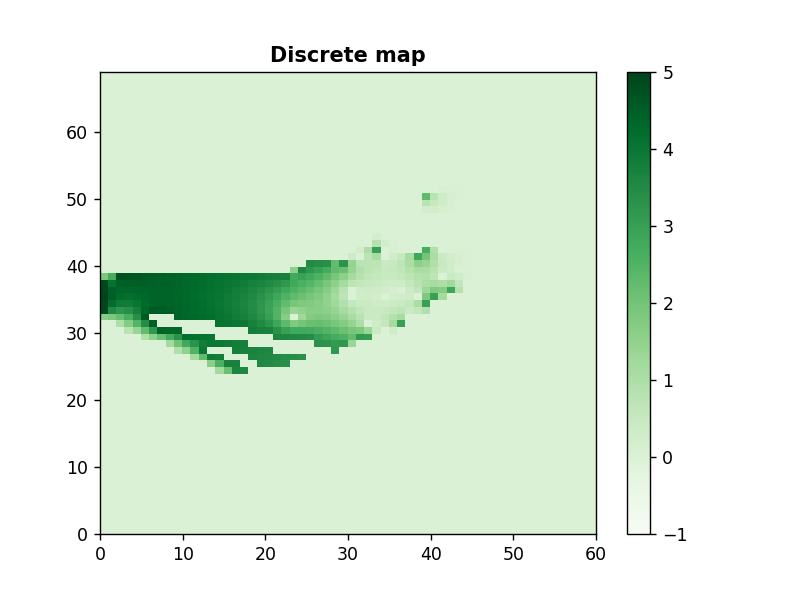

<IPython.core.display.Javascript object>


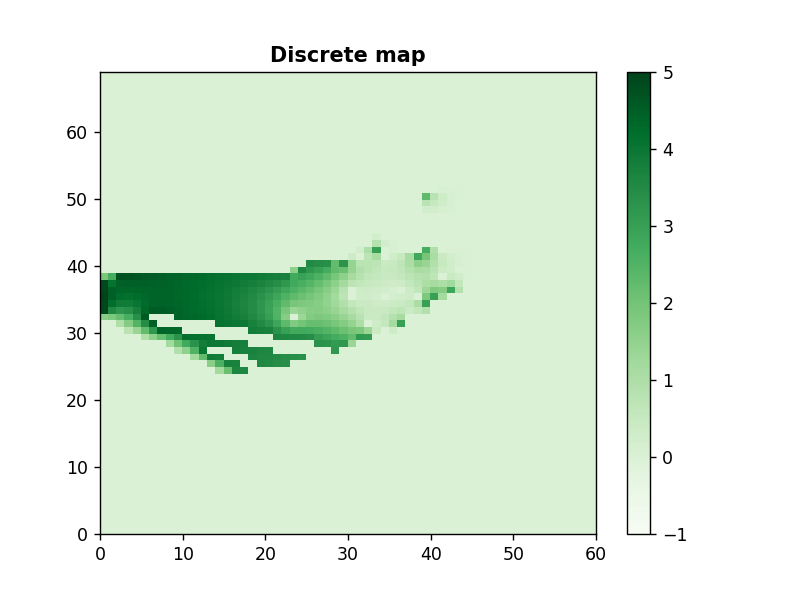

<IPython.core.display.Javascript object>


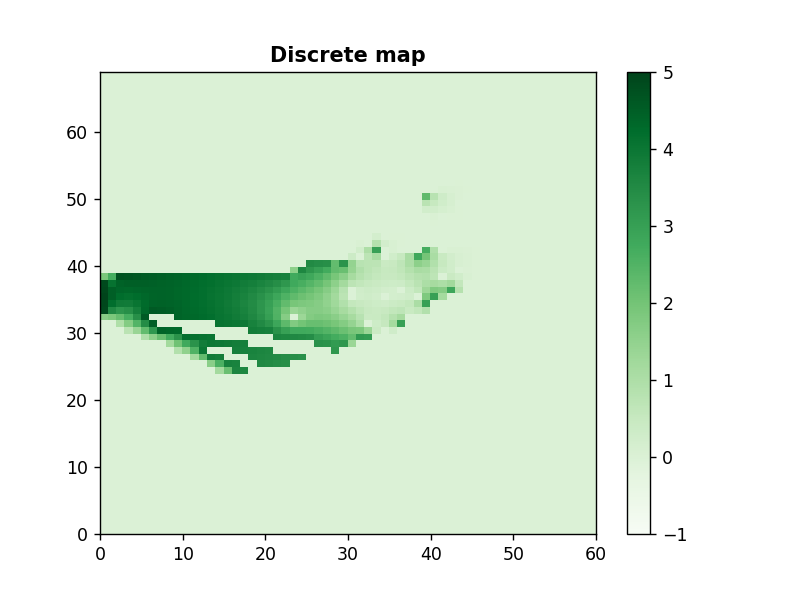

<IPython.core.display.Javascript object>


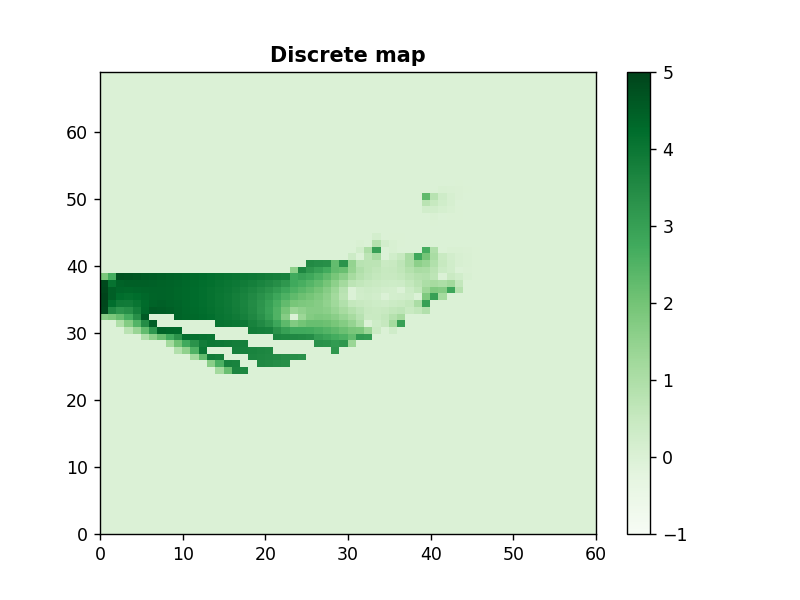

<IPython.core.display.Javascript object>


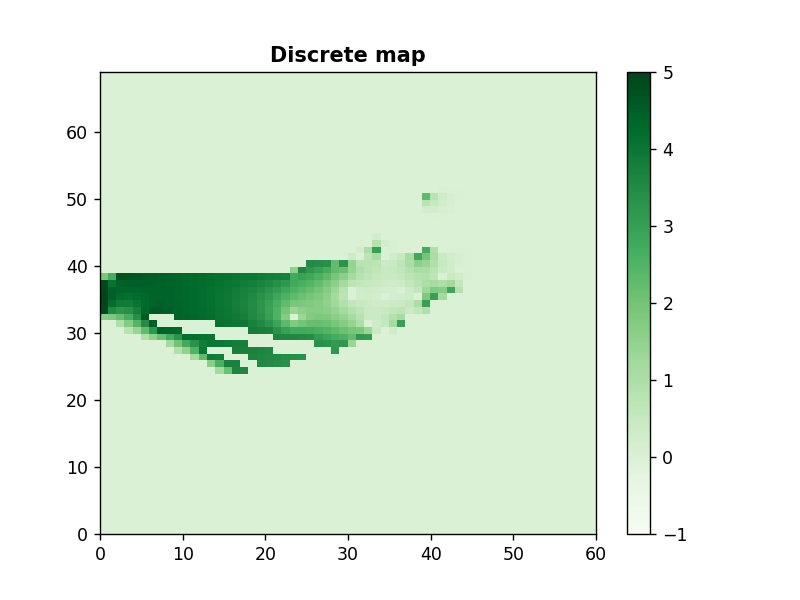

<IPython.core.display.Javascript object>


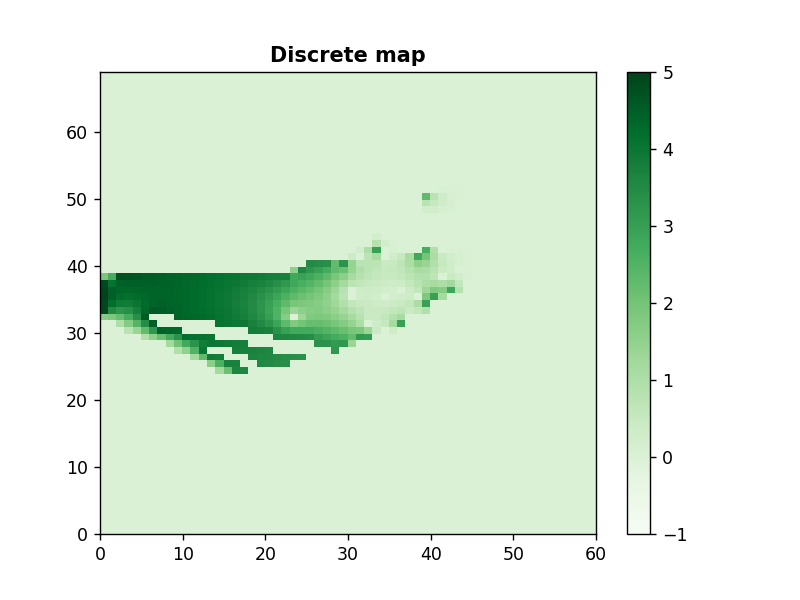

<IPython.core.display.Javascript object>


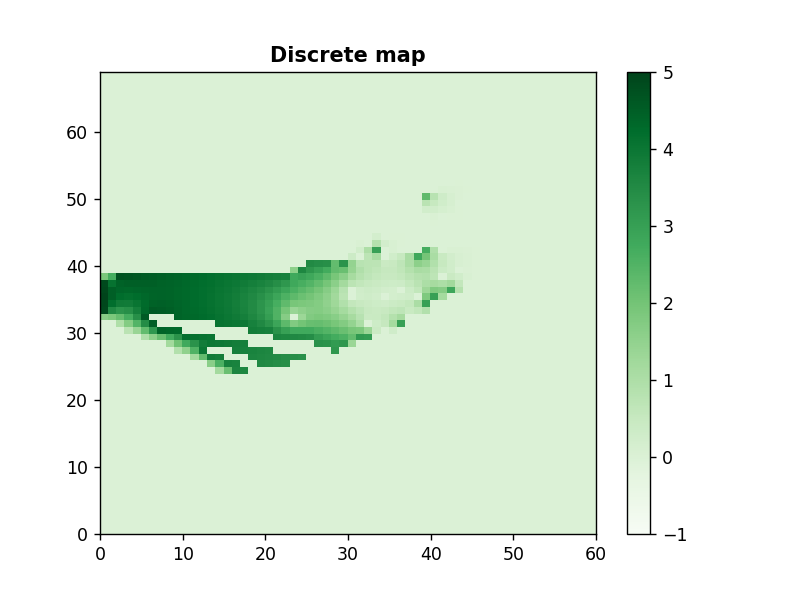

<IPython.core.display.Javascript object>


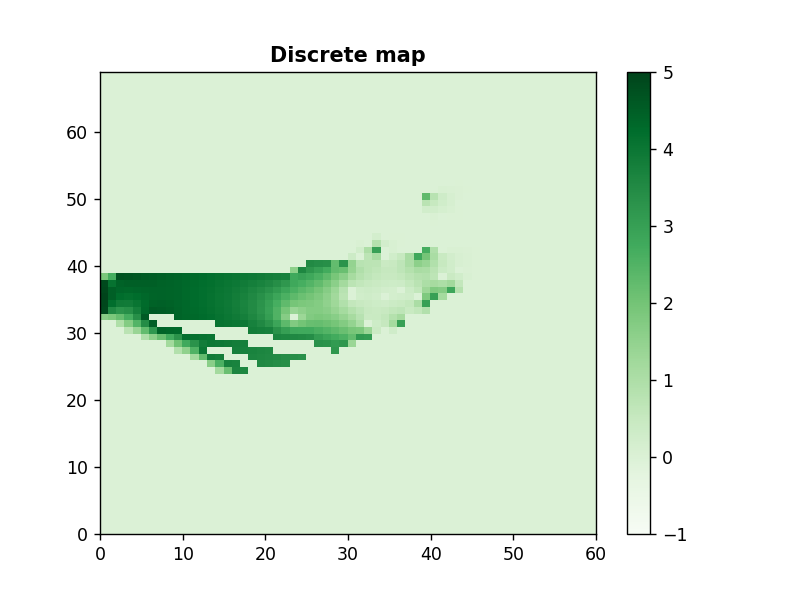

<IPython.core.display.Javascript object>


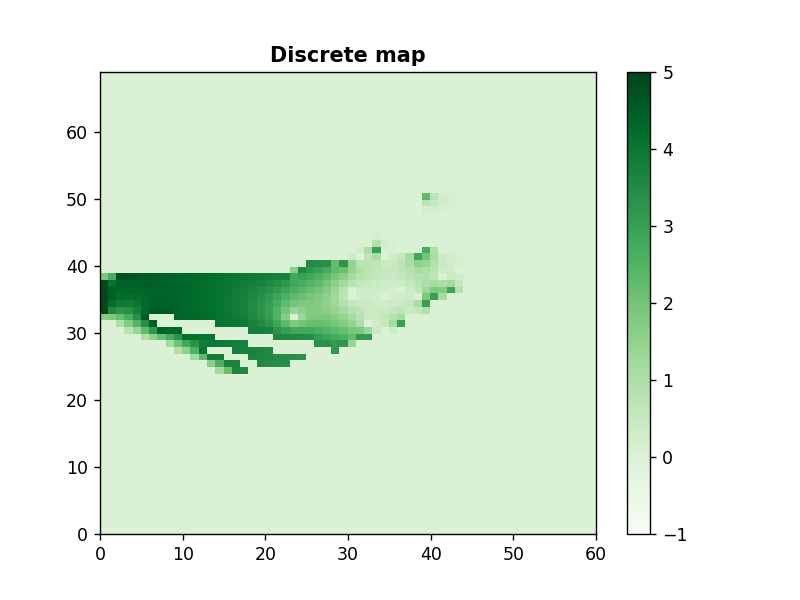

<IPython.core.display.Javascript object>


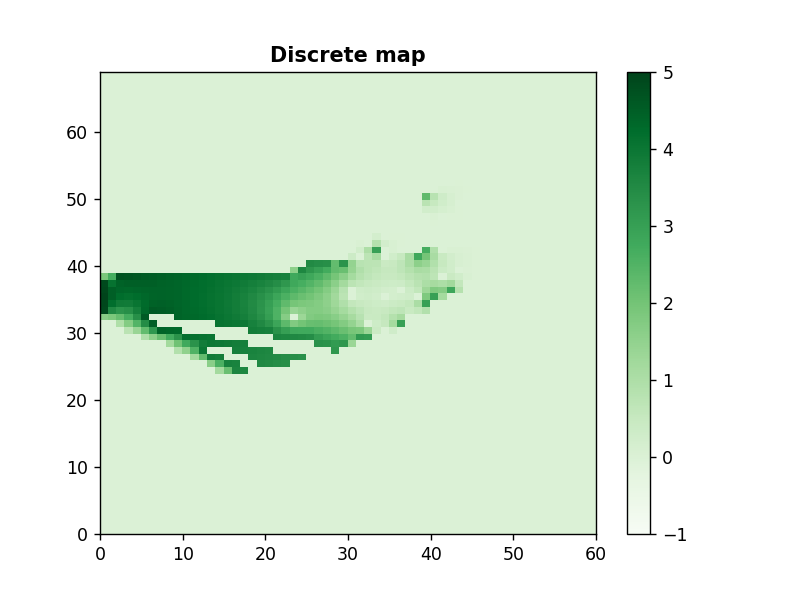

<IPython.core.display.Javascript object>


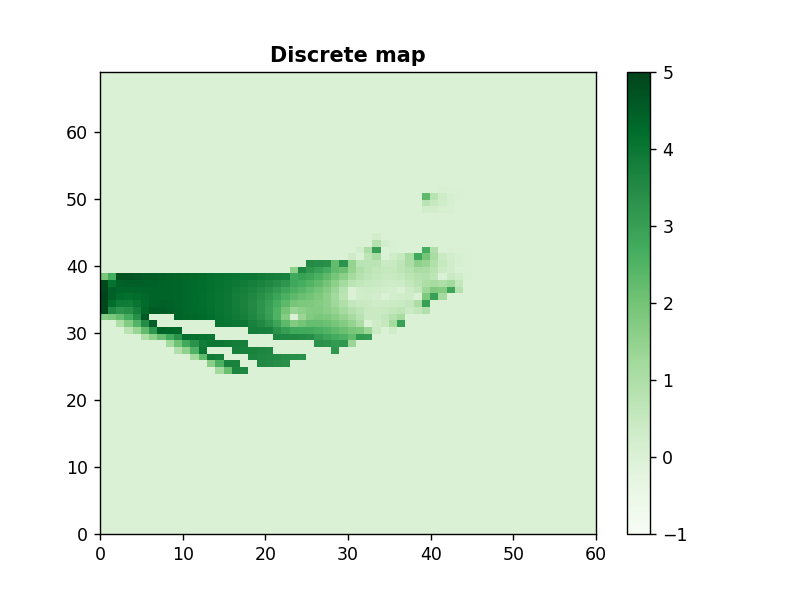

<IPython.core.display.Javascript object>


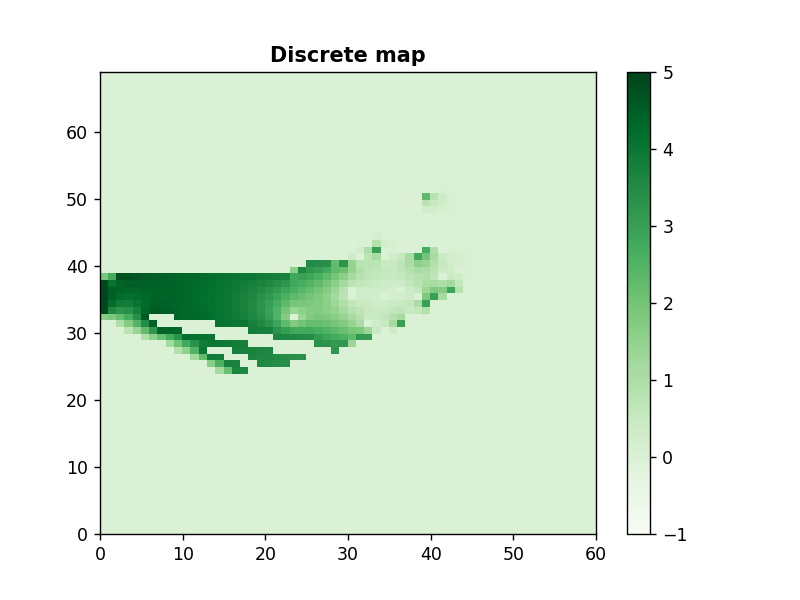

<IPython.core.display.Javascript object>


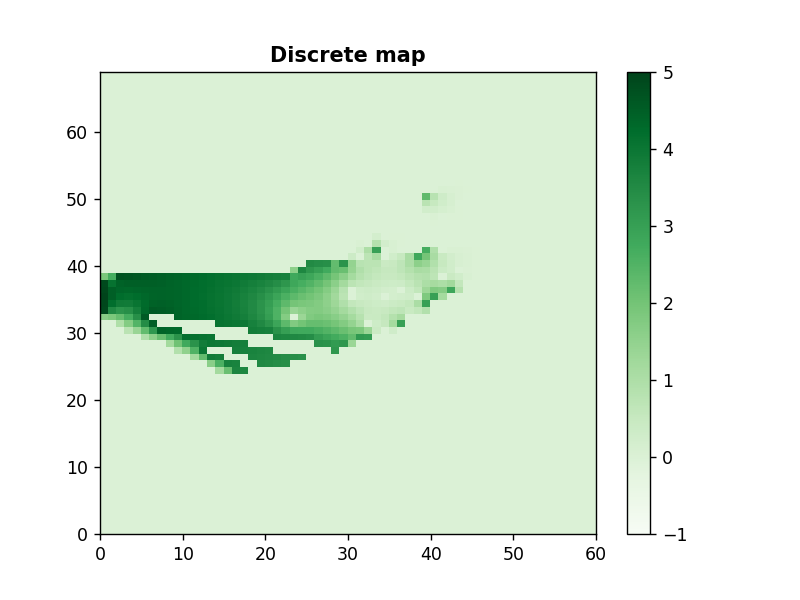

<IPython.core.display.Javascript object>


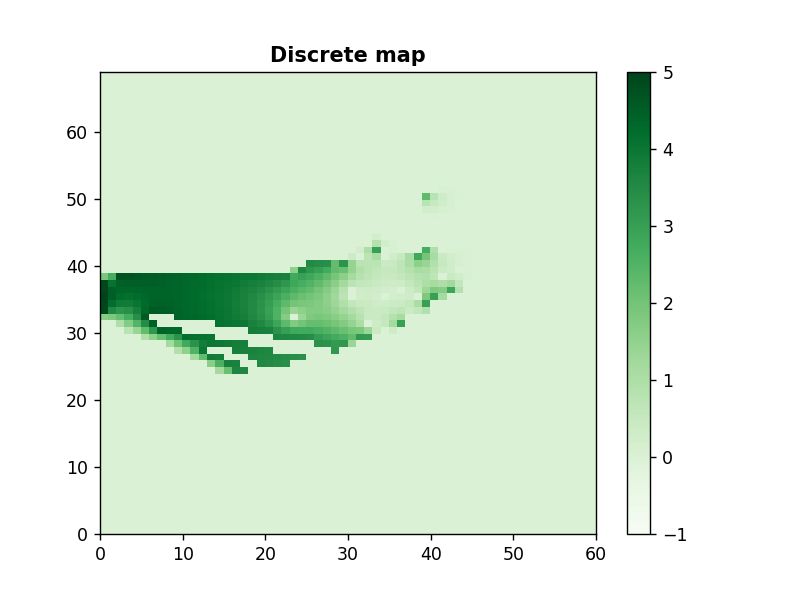

<IPython.core.display.Javascript object>


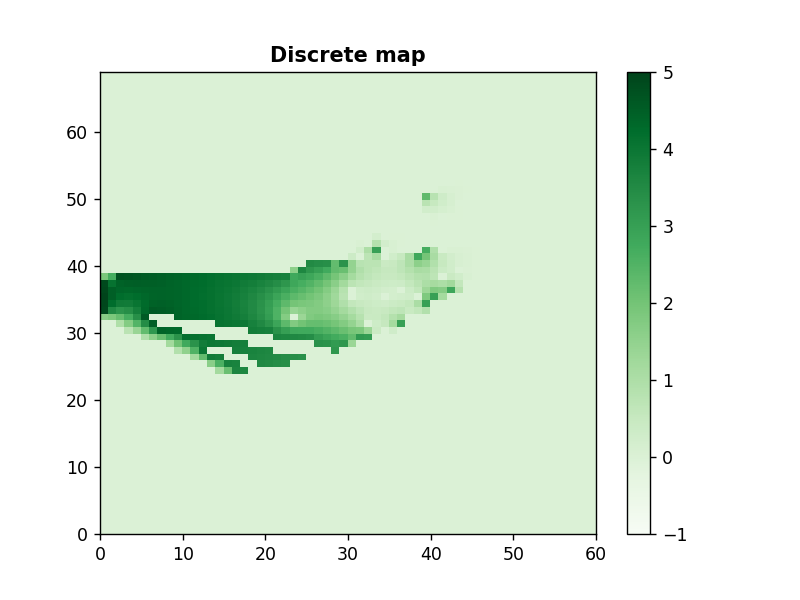

<IPython.core.display.Javascript object>


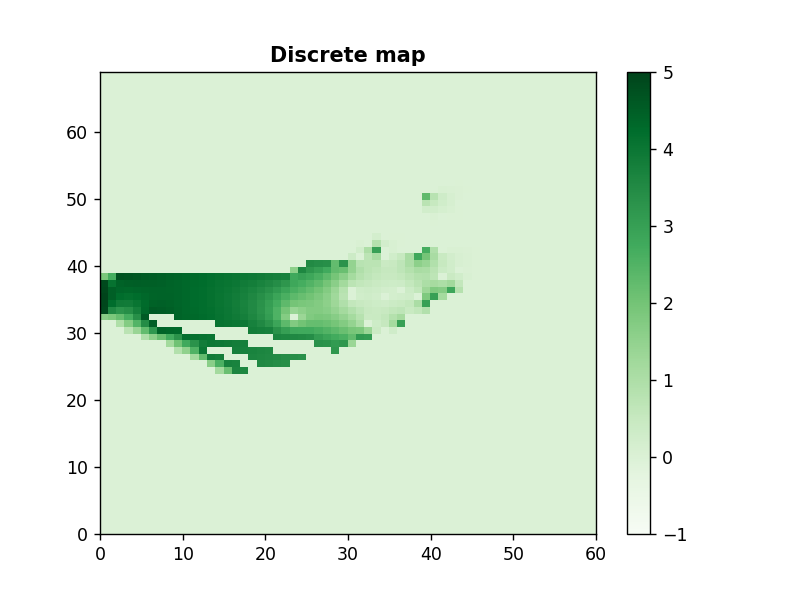

<IPython.core.display.Javascript object>


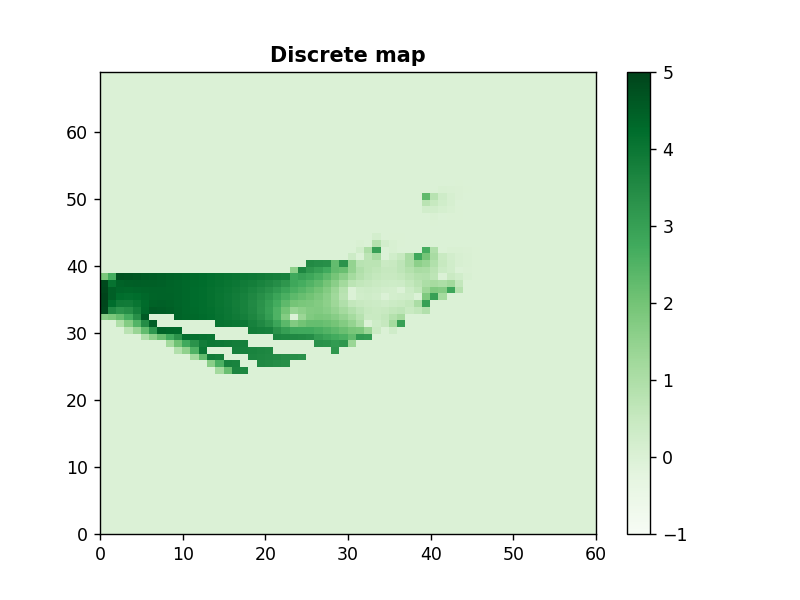

<IPython.core.display.Javascript object>


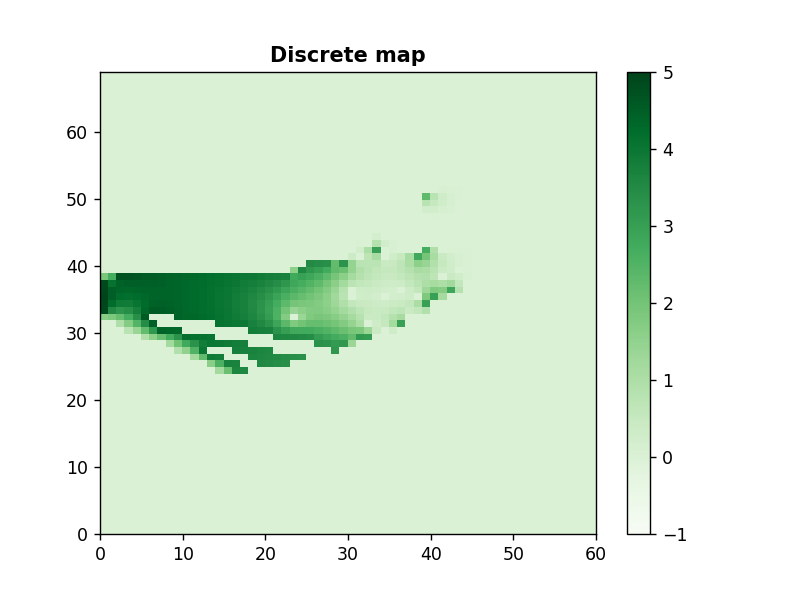

<IPython.core.display.Javascript object>


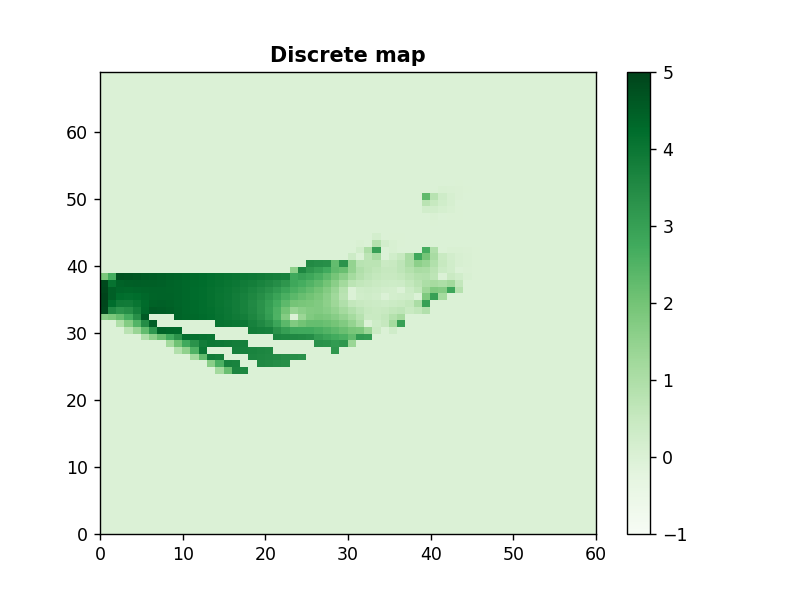

<IPython.core.display.Javascript object>


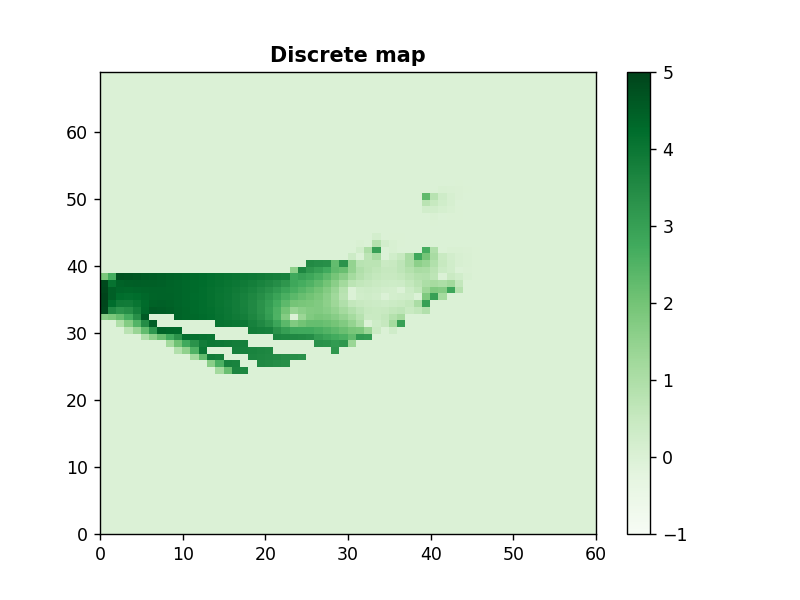

<IPython.core.display.Javascript object>


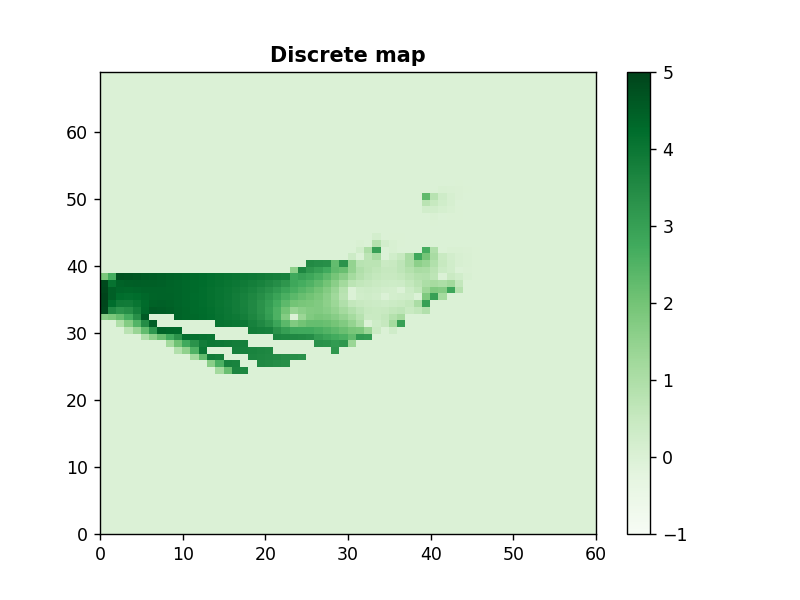

<IPython.core.display.Javascript object>


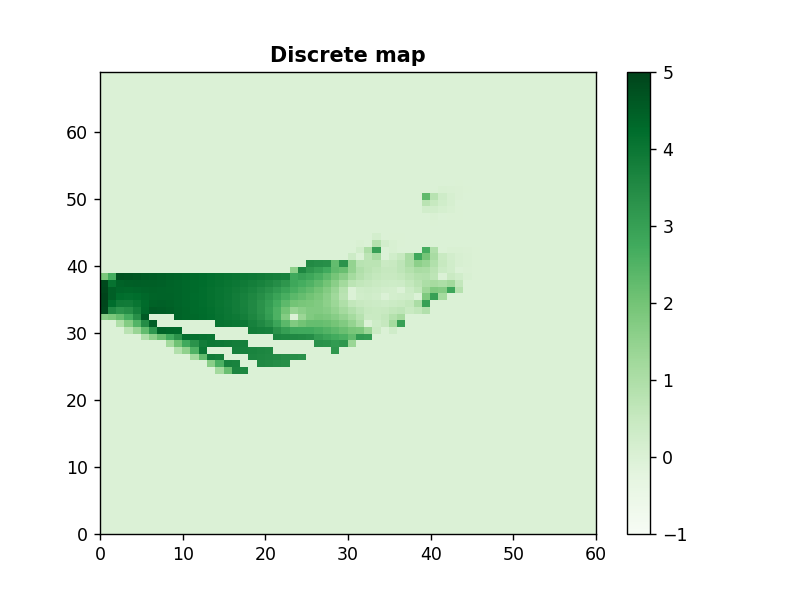

<IPython.core.display.Javascript object>


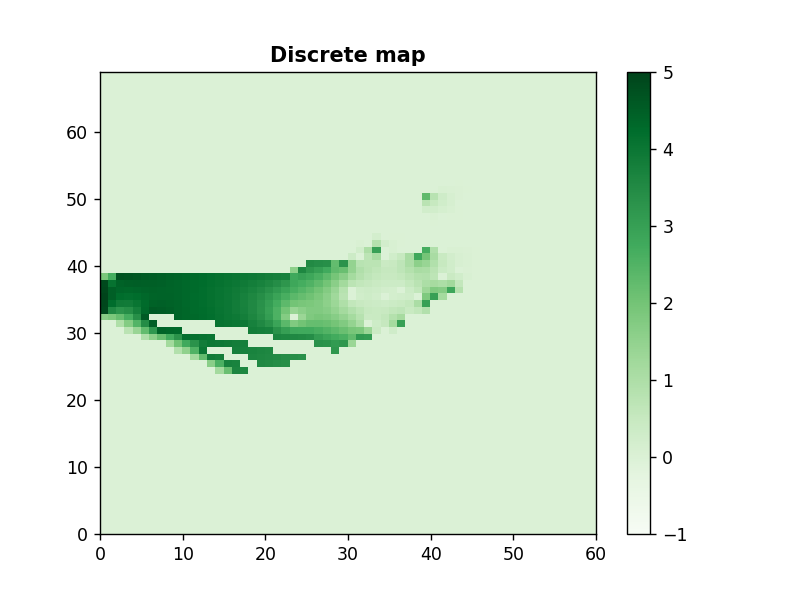

<IPython.core.display.Javascript object>


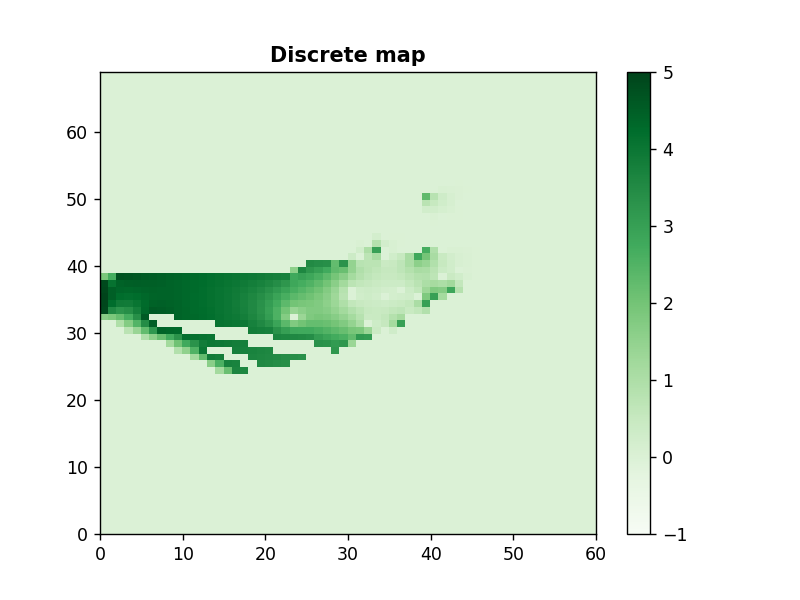

<IPython.core.display.Javascript object>


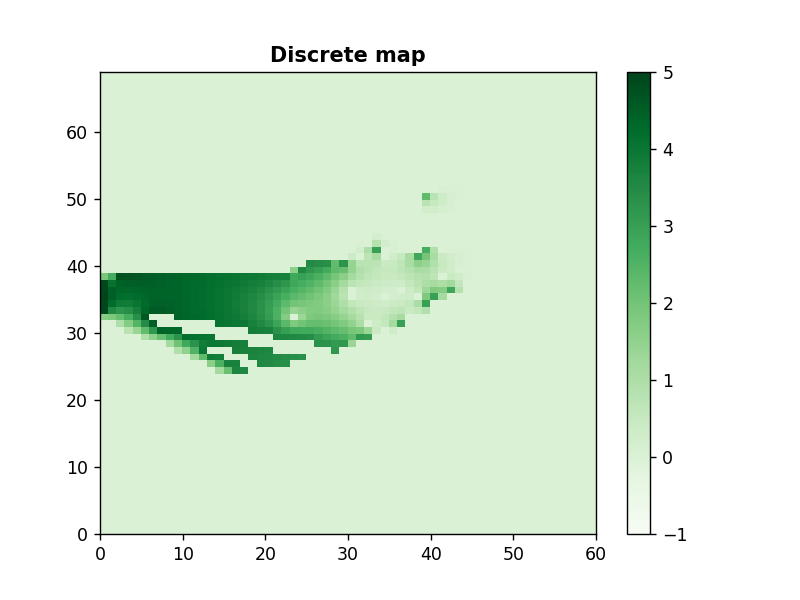

<IPython.core.display.Javascript object>


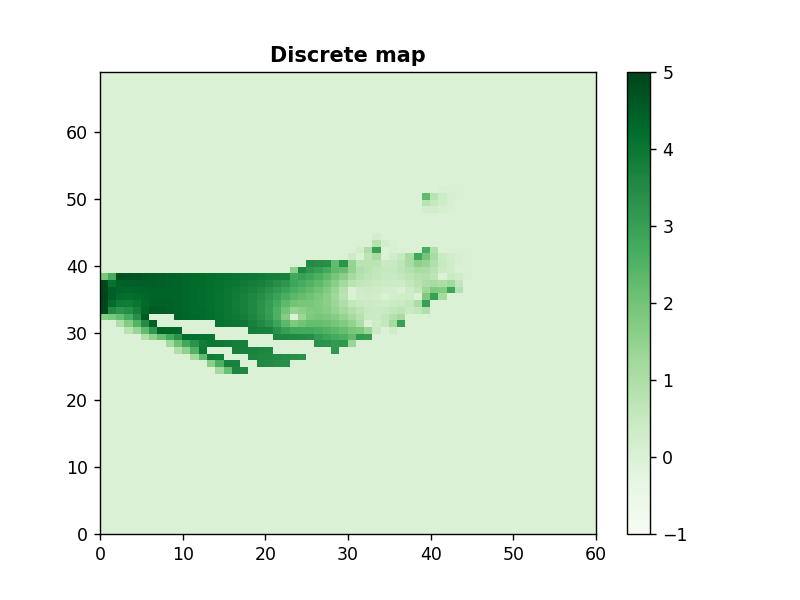

<IPython.core.display.Javascript object>


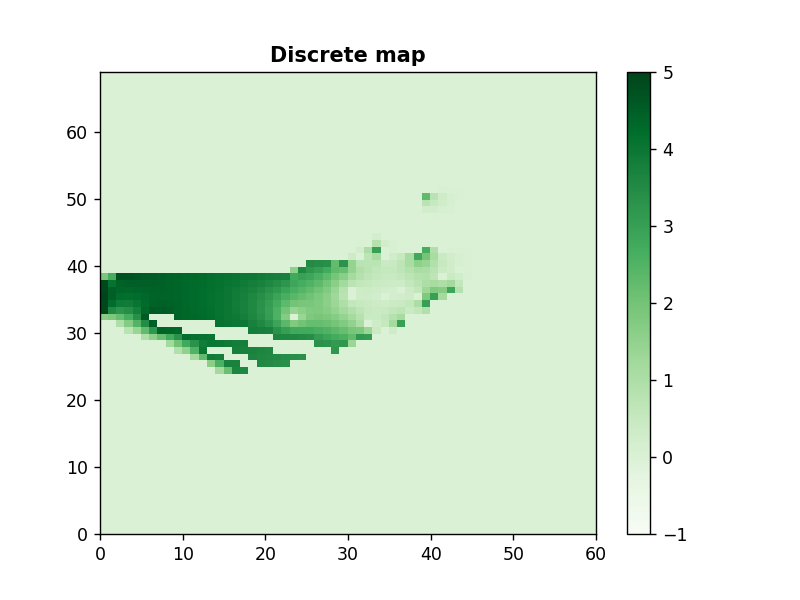

<IPython.core.display.Javascript object>


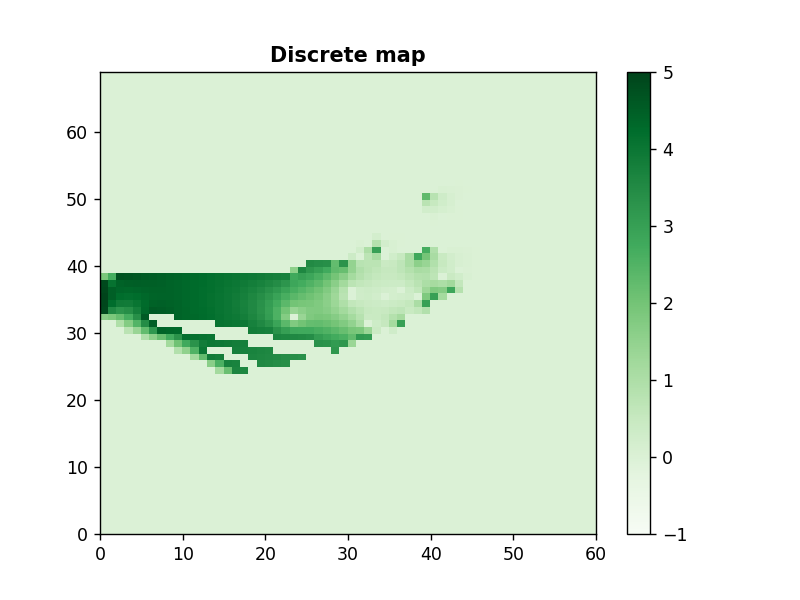

0.49261681257662226


In [8]:
def getPotentialField(grid, walls, goal):
    # TODO: can set no-img cells around the road CC to be 'gradient-free' - take same value as adj valid cells
    NUM_ITER = 100
    U_WALL = 1.0
    U_GOAL = -1.0
    CONSTANT_WALL = False
    nu, nv = grid.shape
    us = np.abs(np.arange(nu) - nu // 2)
    vs = np.arange(nv)
    us, vs = np.meshgrid(vs,us)
    u_walls = 5 - 0.05*(us + vs)
    
    u_grid = np.zeros(grid.shape) # grid.copy().astype('float32')
    u_grid[walls == 1] = U_WALL if CONSTANT_WALL else u_walls[walls==1]
    u_grid[goal] = U_GOAL
    u_grid_dt = np.zeros(u_grid.shape)
    alpha = 0.99
    for i in range(NUM_ITER):
        del_u = np.zeros(u_grid.shape)
        del_u[1:,:] += u_grid[:-1,:]
        del_u[:-1,:] += u_grid[1:,:]
        del_u[:,1:] += u_grid[:,:-1]
        del_u[:,:-1] += u_grid[:,1:]
        del_u = 0.25 * del_u
        u_grid = alpha * del_u + (1.0 - alpha) * u_grid
        u_grid = (grid > 0) * u_grid
        u_grid[walls == 1] = U_WALL if CONSTANT_WALL else u_walls[walls==1]
        u_grid[goal] = U_GOAL
#         plt.figure(20+i)
#         draw_grid(u_grid)
#         plt.savefig('mapdemo_u_field_a=.99_%2d.png' % i, bbox_inches='tight')

    u_grid[walls == 1] = U_WALL if CONSTANT_WALL else u_walls[walls==1]
    u_grid[goal] = U_GOAL

    z_eval = 4       # trick? evaluate gradient ~5-10m ahead to avoid upslope at very start of map frustrum
    dx = 0.5 * (u_grid[nu // 2 + 1, z_eval] - u_grid[nu // 2 - 1, z_eval])
    dz = u_grid[nu // 2, 0 + 1] - u_grid[nu // 2, int(max(z_eval - 1, 0))]
    if dz < 0:
        dx = -dx
        dz = -dz
    heading = np.arctan2(dx, dz)
    return heading, u_grid

    
#     NUM_STEPS = 20
#     headings = np.zeros(NUM_STEPS)
#     p_time = np.zeros((NUM_STEPS, 2))
#     x = nu // 2
#     z = 0
#     for i in range(NUM_STEPS):
#         dz = u_grid[int(x // 1), int(z // 1) + 1] - u_grid[int(x // 1), int(z // 1)]
#         dx = 0.5 * (u_grid[int(x // 1) + 1, int(z // 1)] - u_grid[int(x // 1) - 1, int(z // 1)])
#         if dz < 0:
#             dx = -dx
#             dz = -dz

#         grad = np.sqrt(dx**2 + dz**2)
#         if grad == 0:
#             print("divide by zero!")
#             break
#         dz *= 2.5/grad
#         dx *= 2.5/grad
#         x = int(x + dx)
#         z = int(z + dz)
#         heading = np.arctan2(dx, dz)

# #         heading = np.arccos(np.abs(dz) / np.sqrt(dx**2 + dz**2))

#         if x >= nu or x < 0 or z > nv or z < 0:
#             break
#         p_time[i,:] = [x,z]
#         headings[i] = heading
#     for i in range(NUM_STEPS):
#         u_grid[int(p_time[i,0]),int(p_time[i,1])] = -1

hdg, field = getPotentialField(x,walls,goal)
print(hdg)
plt.figure(23)
draw_grid(field)
# plt.savefig('mapdemo_u_field_%d.png' % i, bbox_inches='tight')

In [ ]:
nu, nv = field.shape
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(nv)
Y = np.arange(nu)
X, Y = np.meshgrid(X, Y)
Z = field

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(np.min(Z)-0.1, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()